# Insurance Fraud Claim Detection

A leading global insurer, an Infosys client, was using multiple claims processing systems and prcoesses across more than a hundred countries. The diverse systems across different geographies made it arduous to settle claims, and also affected the accuracy of information and fraud detection.
<br>
All the existing claims were migrated from legacy applications to the new platform. The platform was equipped with predictive analytics, which helped reducing the time taken to serve customers and insurance claim fraud detection.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

from xgboost import XGBClassifier, plot_importance

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
df = pd.read_csv('insurance_fraud_claims.csv')

In [3]:
df.shape

(1000, 40)

## Data Cleaning

In [4]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [5]:
missing_stats = []

for col in df.columns:
    missing_stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    
stats_df = pd.DataFrame(missing_stats, columns=['feature', 'unique_values', 'percent_missing', 'percent_biggest_cat', 'type'])
stats_df.sort_values('feature', ascending=True)

,feature,unique_values,percent_missing,percent_biggest_cat,type
39,_c39,0,100.0,100.0,float64
1,age,46,0.0,4.9,int64
21,authorities_contacted,5,0.0,29.2,object
35,auto_make,14,0.0,8.0,object
36,auto_model,39,0.0,4.3,object
37,auto_year,21,0.0,5.6,int64
28,bodily_injuries,3,0.0,34.0,int64
15,capital-gains,338,0.0,50.8,int64
16,capital-loss,354,0.0,47.5,int64
19,collision_type,4,0.0,29.2,object


In [6]:
df.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,_c39
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,0.0
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000,NaN
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861,NaN
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000,NaN
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000,NaN
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000,NaN
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000,NaN
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000,NaN


In [7]:
#a feature with no values has no value

df.drop('_c39', axis=1, inplace=True)

In [8]:
#extract out the year as 

df['policy_bind_year']=df['policy_bind_date'].str.extract('(\d{4})\-').astype('int32')

In [9]:
#all accidents are from jan and feb of same year, so year isnt very important

df['incident_month']=df['incident_date'].str.extract('\d{4}\-(\d{2})').astype('int32')

In [10]:
#replace "?" with undocumented 

df['collision_type'] = df['collision_type'].replace("?", "undocumented")
df['police_report_available'] = df['police_report_available'].replace("?", "undocumented")
df['property_damage'] = df['property_damage'].replace("?", "undocumented")
df['auto_make'] = df['auto_make'].replace("Suburu", "Subaru")

In [11]:
#incident_severity can be seen as ordinal
#code them in order of severity 

df['incident_severity'] = df['incident_severity'].map({"Trivial Damage":0,
                                                       "Minor Damage":1,
                                                       "Major Damage":2,
                                                       "Total Loss":3
                                                      }).astype("int32")
df.incident_severity.value_counts()

1    354
3    280
2    276
0     90
Name: incident_severity, dtype: int64

In [12]:
#umbrella limit is like an insruance topup that pays your liabilities in case you get sued
#cannot be zero
#this 0 is an error

df['umbrella_limit'].sort_values(ascending=True)

290    -1000000
0             0
623           0
624           0
625           0
         ...   
657     9000000
458     9000000
975     9000000
430    10000000
115    10000000
Name: umbrella_limit, Length: 1000, dtype: int64

In [13]:
#edit to positve
df['umbrella_limit'].iloc[290] = 1000000

C:\Users\DELL\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [14]:
#check
df['umbrella_limit'].iloc[290]

1000000

#### Identify by data types

In [15]:
all_var = list(df.columns)
len(all_var)

41

In [16]:
#continuous variables = ordinal, interval, ratio

cont_var =['age','incident_hour_of_the_day',
           'number_of_vehicles_involved','total_claim_amount',
           'injury_claim','property_claim','vehicle_claim',
           'months_as_customer','policy_annual_premium','policy_deductable',
           'umbrella_limit','capital-gains','capital-loss', 
           'auto_year','witnesses','bodily_injuries','policy_bind_year','incident_severity']

len(cont_var)

18

In [17]:
#ordinal var

ord_var = ['policy_deductable','witnesses','bodily_injuries','incident_severity']
len(ord_var)

4

In [18]:
#quan var = interval or ratio 

quan_var = (list(set(cont_var) - set(ord_var))) 
len(quan_var)

14

In [19]:
#norminal variables

nom_var = (list(set(all_var) - set(cont_var))) 
len(nom_var)

23

In [20]:
#check for norminal data with vevry large number of categories

for col in nom_var:
    print("###", col, "###" )
    print("  ")
    print(df[col].value_counts())
    print("---------------------------------------------")
    print("  ")

### insured_hobbies ###
  
reading           64
paintball         57
exercise          57
bungie-jumping    56
camping           55
movies            55
golf              55
kayaking          54
yachting          53
hiking            52
video-games       50
skydiving         49
base-jumping      49
board-games       48
polo              47
chess             46
dancing           43
sleeping          41
cross-fit         35
basketball        34
Name: insured_hobbies, dtype: int64
---------------------------------------------
  
### policy_bind_date ###
  
1992-08-05    3
1992-04-28    3
2006-01-01    3
1992-04-14    2
2013-12-25    2
             ..
2012-12-22    1
2008-01-01    1
1996-12-21    1
2000-08-15    1
2002-10-12    1
Name: policy_bind_date, Length: 951, dtype: int64
---------------------------------------------
  
### auto_make ###
  
Subaru        80
Saab          80
Dodge         80
Nissan        78
Chevrolet     76
Ford          72
BMW           72
Toyota        70
Audi    

In [21]:
#for those that have not too many unique, we can plot them out

large_cat = []

for col in nom_var:
    if df[col].nunique() > 20:
        large_cat.append(col)
        print(col, df[col].nunique())
    else: 
        pass
    
#incident location, insured zip, policy bind date, policy number too many unique to be meaningful

policy_bind_date 951
insured_zip 995
incident_location 1000
auto_model 39
policy_number 1000
incident_date 60


In [22]:
#get a data frame with var that have large num categories
#only auto model 
large_dummy = pd.get_dummies(df[['auto_model','incident_date']], drop_first=True)

#put in the DV
large_dummy['fraud_reported']=df['fraud_reported']

#numerical code the DV
large_dummy['fraud_reported'] = large_dummy['fraud_reported'].map({"Y":1,"N":0})

#unique to each case. wont be useful
large_dummy.head(10)


,auto_model_92x,auto_model_93,auto_model_95,auto_model_A3,auto_model_A5,auto_model_Accord,auto_model_C300,auto_model_CRV,auto_model_Camry,auto_model_Civic,auto_model_Corolla,auto_model_E400,auto_model_Escape,auto_model_F150,auto_model_Forrestor,auto_model_Fusion,auto_model_Grand Cherokee,auto_model_Highlander,auto_model_Impreza,auto_model_Jetta,auto_model_Legacy,auto_model_M5,auto_model_MDX,auto_model_ML350,auto_model_Malibu,auto_model_Maxima,auto_model_Neon,auto_model_Passat,auto_model_Pathfinder,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6,incident_date_2015-01-02,incident_date_2015-01-03,incident_date_2015-01-04,incident_date_2015-01-05,incident_date_2015-01-06,incident_date_2015-01-07,incident_date_2015-01-08,incident_date_2015-01-09,incident_date_2015-01-10,incident_date_2015-01-11,incident_date_2015-01-12,incident_date_2015-01-13,incident_date_2015-01-14,incident_date_2015-01-15,incident_date_2015-01-16,incident_date_2015-01-17,incident_date_2015-01-18,incident_date_2015-01-19,incident_date_2015-01-20,incident_date_2015-01-21,incident_date_2015-01-22,incident_date_2015-01-23,incident_date_2015-01-24,incident_date_2015-01-25,incident_date_2015-01-26,incident_date_2015-01-27,incident_date_2015-01-28,incident_date_2015-01-29,incident_date_2015-01-30,incident_date_2015-01-31,incident_date_2015-02-01,incident_date_2015-02-02,incident_date_2015-02-03,incident_date_2015-02-04,incident_date_2015-02-05,incident_date_2015-02-06,incident_date_2015-02-07,incident_date_2015-02-08,incident_date_2015-02-09,incident_date_2015-02-10,incident_date_2015-02-11,incident_date_2015-02-12,incident_date_2015-02-13,incident_date_2015-02-14,incident_date_2015-02-15,incident_date_2015-02-16,incident_date_2015-02-17,incident_date_2015-02-18,incident_date_2015-02-19,incident_date_2015-02-20,incident_date_2015-02-21,incident_date_2015-02-22,incident_date_2015-02-23,incident_date_2015-02-24,incident_date_2015-02-25,incident_date_2015-02-26,incident_date_2015-02-27,incident_date_2015-02-28,incident_date_2015-03-01,fraud_reported
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [23]:
#Color negative numbers red, positive blue
def color(val):
    color = 'green' if val ==1 else 'red' if val < -0.3 else 'blue' if val > 0.3 else 'black'   #write like lambda
    return 'color: %s' % color


corr = large_dummy.corr()
corr.style.applymap(color)


#no correlation with make and fraud. drop var

,auto_model_92x


In [24]:
#drop this variables from analysis 

df.drop(large_cat, axis=1, inplace=True)

In [25]:
#redefine the norminal var
#remove dv from the list

nom_var.remove('fraud_reported')
nom_var = (list(set(nom_var) - set(large_cat))) 
len(nom_var)

16

In [26]:
#check columns add up 

print ('total var count:{}'.format(len(list(df.columns))),
       'continous var count:{}'.format(len(cont_var)),
       'norminal var count:{}'.format(len(nom_var)))

total var count:35 continous var count:18 norminal var count:16


## Exploratory Data Analysis

### Dependent variable
Exploratory data analysis was conducted started with the dependent variable, Fraud_reported. There were 247 frauds and 753 non-frauds. 24.7% of the data were frauds while 75.3% were non-fraudulent claims. 

In [27]:
#count each level of the Dv

df.fraud_reported.value_counts()

N    753
Y    247
Name: fraud_reported, dtype: int64

In [28]:
#proportion of each level of DV

df.fraud_reported.value_counts(normalize=True)

N    0.753
Y    0.247
Name: fraud_reported, dtype: float64

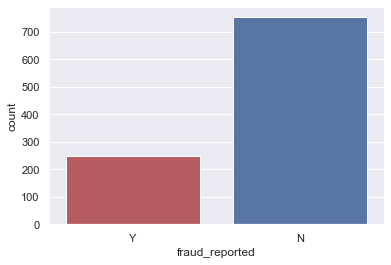

In [29]:
#dist of dv
#plt.style.use('dark_background') for ppt 
sns.set()

sns.countplot(x ="fraud_reported", data=df, palette=['r','b']);

### Correlations among variables
Next, correlations amongst continuous variables were inspected. Heatmap was plotted for variables with at least 0.3 Pearson's correlation coefficient.

Month as customer and age had a correlation of 0.92. Probably because drivers buy auto insurance when they own a car and this time measure only increases with age. 

Incident severity and different types of claims have a clear correlation ($r$ = 0.36 - 0.50)

Apart from that, there don’t seem to be much correlations in the data.
There don’t seem to be multicollinearity problem except maybe that all the claims are all correlated, and somehow total claims have accounted for them.
However, the other claims provide some granularity that will not otherwise be captured by total claims. Thus, these variables were kept. 

In [30]:
#Color negative numbers red

def color(val):
    color = 'green' if val ==1 else 'red' if val < -0.3 else 'blue' if val > 0.3 else 'black'   #write like lambda
    return 'color: %s' % color


corr = df[cont_var].corr()
corr.style.applymap(color)

,age,incident_hour_of_the_day,number_of_vehicles_involved,total_claim_amount,injury_claim,property_claim,vehicle_claim,months_as_customer,policy_annual_premium,policy_deductable,umbrella_limit,capital-gains,capital-loss,auto_year,witnesses,bodily_injuries,policy_bind_year,incident_severity
age,1.000000,0.087161,0.022102,0.069863,0.075522,0.060898,0.062588,0.922098,0.014404,0.029188,0.018425,-0.007075,0.007368,0.001354,0.052359,-0.015679,-0.037444,0.009513
incident_hour_of_the_day,0.087161,1.000000,0.120794,0.217702,0.165768,0.179536,0.215626,0.070639,-0.001578,0.060935,-0.023097,-0.016406,-0.025054,0.021368,0.006527,-0.034563,0.035412,0.188339
number_of_vehicles_involved,0.022102,0.120794,1.000000,0.274278,0.224650,0.219084,0.269393,0.014736,-0.045991,0.051214,-0.021997,0.061643,-0.014895,0.034554,-0.014669,0.014030,0.026595,0.237425
total_claim_amount,0.069863,0.217702,0.274278,1.000000,0.805025,0.810686,0.982773,0.062108,0.009094,0.022839,-0.038994,0.015980,-0.036060,-0.035781,-0.011114,0.047093,-0.000146,0.495676
injury_claim,0.075522,0.165768,0.224650,0.805025,1.000000,0.563866,0.722878,0.065329,-0.017633,0.039107,-0.045229,0.025934,-0.046060,-0.013718,-0.024843,0.047319,0.002529,0.361477
property_claim,0.060898,0.179536,0.219084,0.810686,0.563866,1.000000,0.732090,0.034940,-0.011654,0.064792,-0.022044,-0.000779,-0.022863,-0.014508,0.052640,0.039749,-0.000970,0.384283
vehicle_claim,0.062588,0.215626,0.269393,0.982773,0.722878,0.732090,1.000000,0.061013,0.020246,0.005269,-0.037190,0.015836,-0.032665,-0.042768,-0.022564,0.043449,-0.000610,0.501328
months_as_customer,0.922098,0.070639,0.014736,0.062108,0.065329,0.034940,0.061013,1.000000,0.005018,0.026807,0.016111,0.006399,0.020209,-0.000292,0.058383,-0.010162,-0.048276,0.003005
policy_annual_premium,0.014404,-0.001578,-0.045991,0.009094,-0.017633,-0.011654,0.020246,0.005018,1.000000,-0.003245,-0.005956,-0.013738,0.023547,-0.049226,0.002332,0.026780,0.001249,0.020233
policy_deductable,0.029188,0.060935,0.051214,0.022839,0.039107,0.064792,0.005269,0.026807,-0.003245,1.000000,0.009968,0.035212,-0.023544,0.026105,0.066639,-0.022765,-0.049598,0.012795


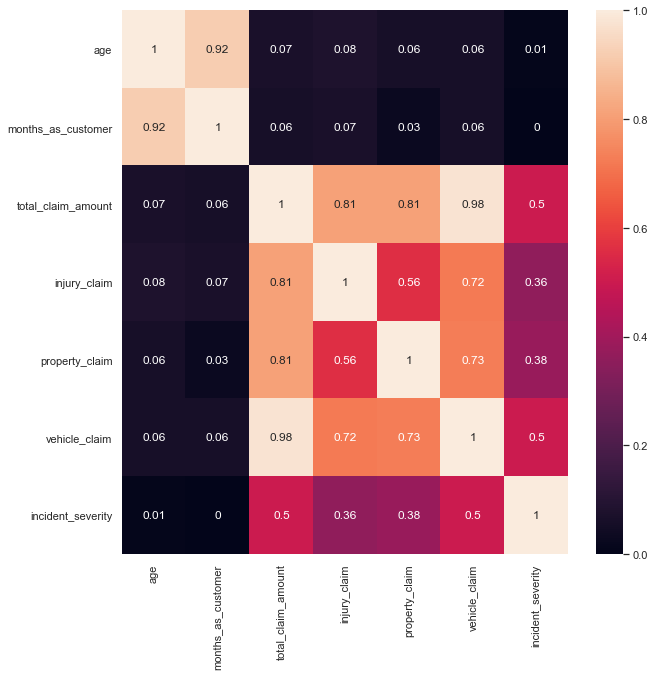

In [31]:
sns.set_style('white')
plt.figure(figsize=(10,10))
# heatmap from those with at least 0.3 magnitude in corr, includeing the DV
corr_list=['age','months_as_customer','total_claim_amount',
           'injury_claim', 'property_claim','vehicle_claim',
           'incident_severity','fraud_reported']

corr_df = df[corr_list]
corr=round(corr_df.corr(),2)
sns.heatmap(corr, annot=True)
plt.show()

## Visualization

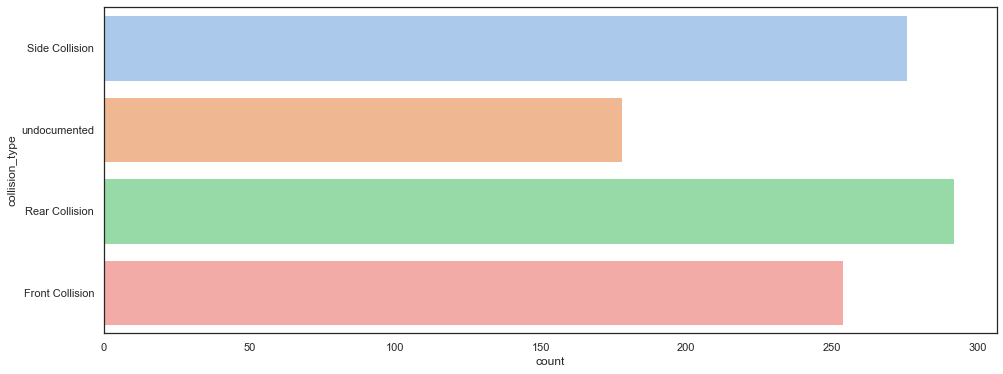

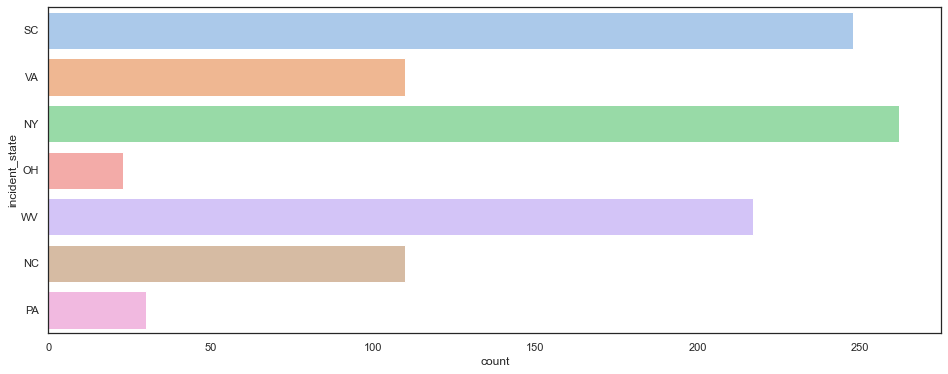

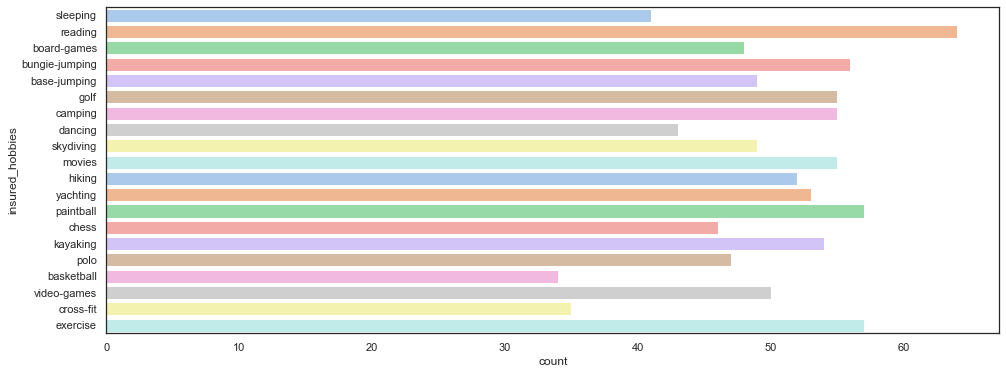

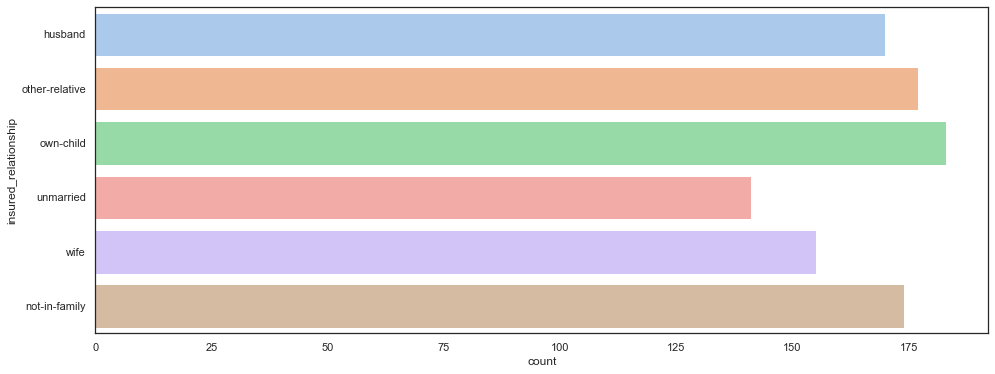

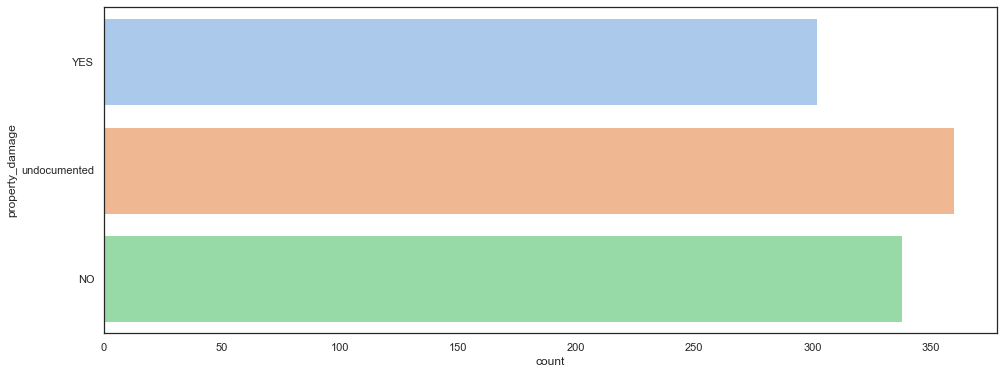

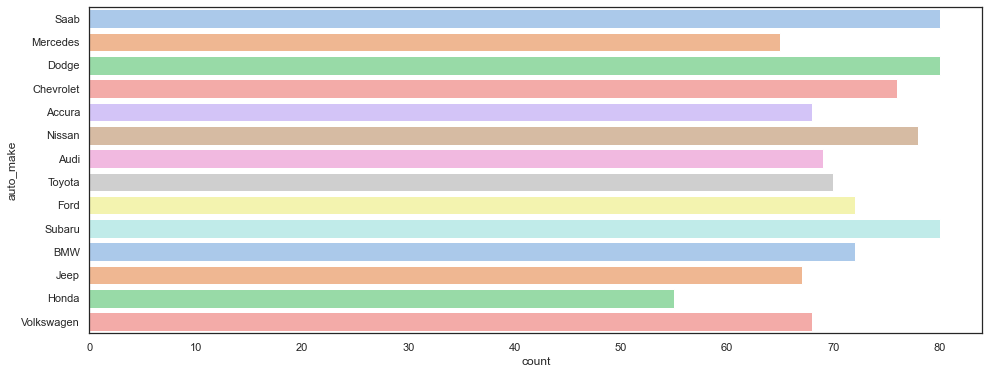

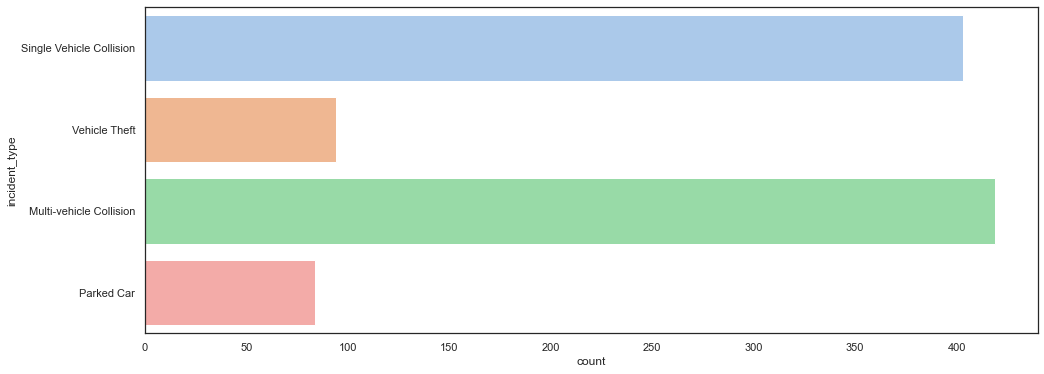

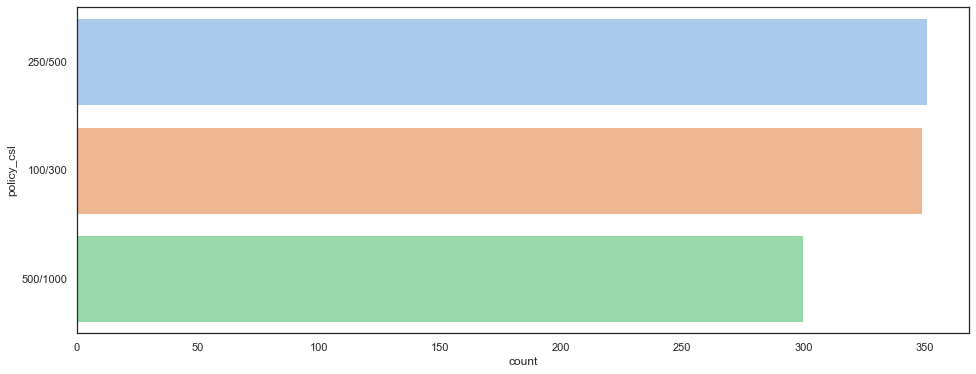

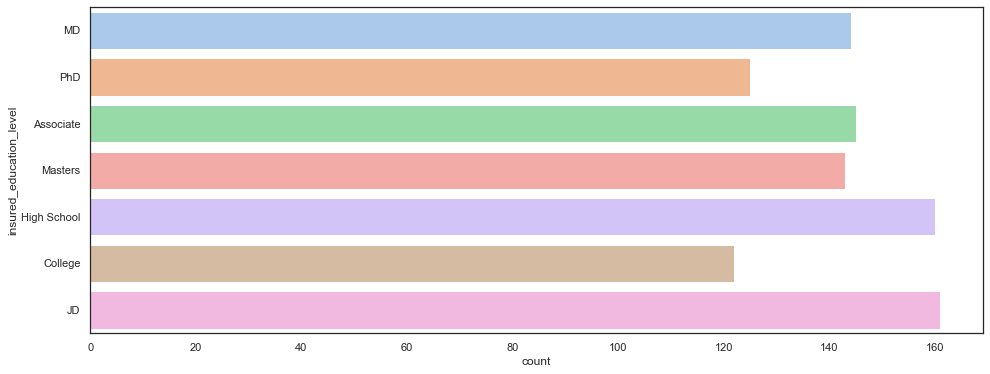

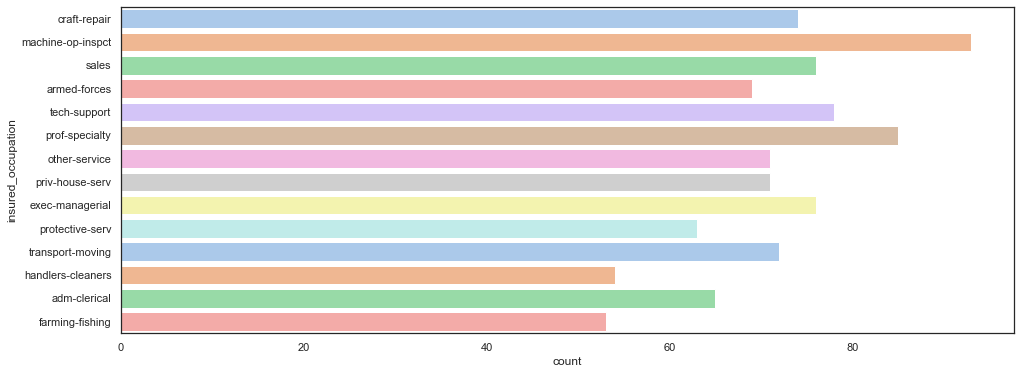

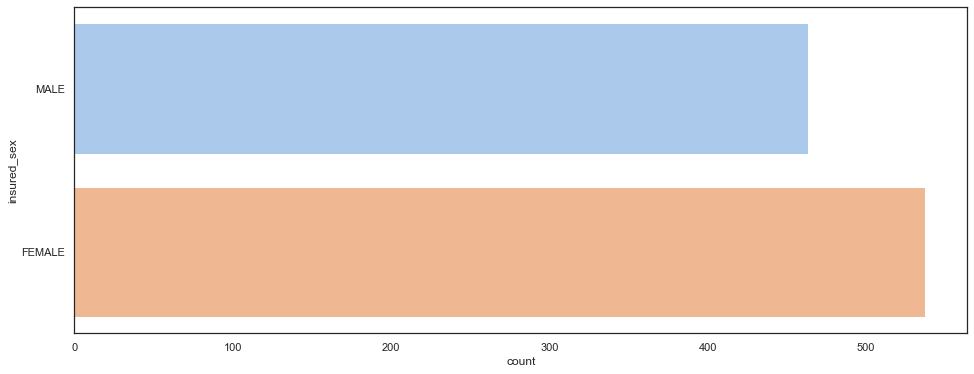

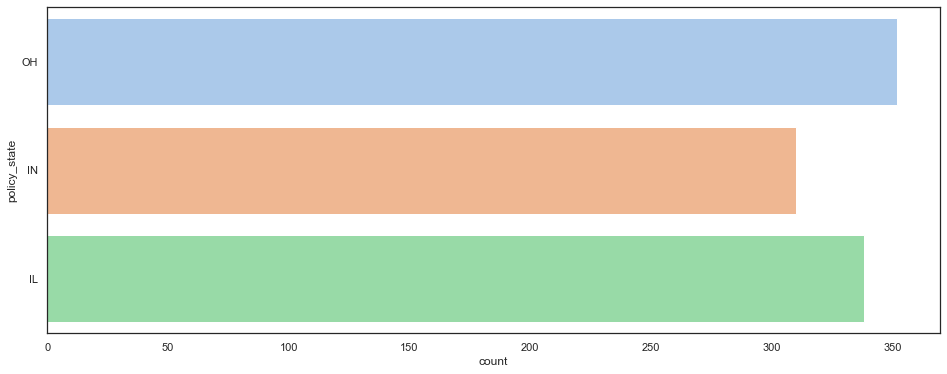

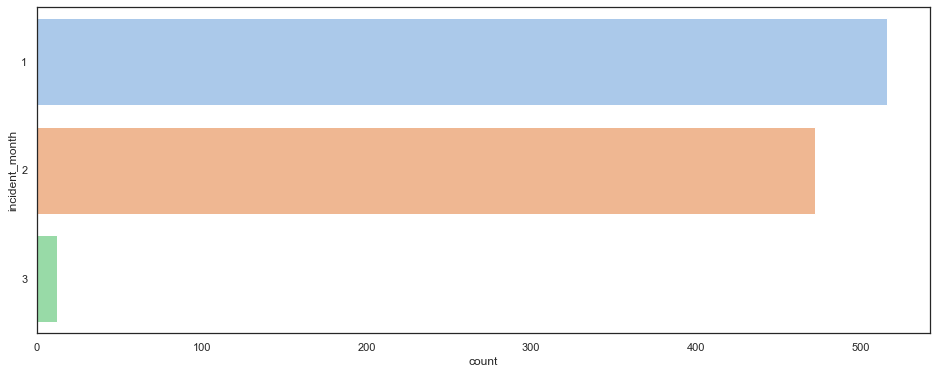

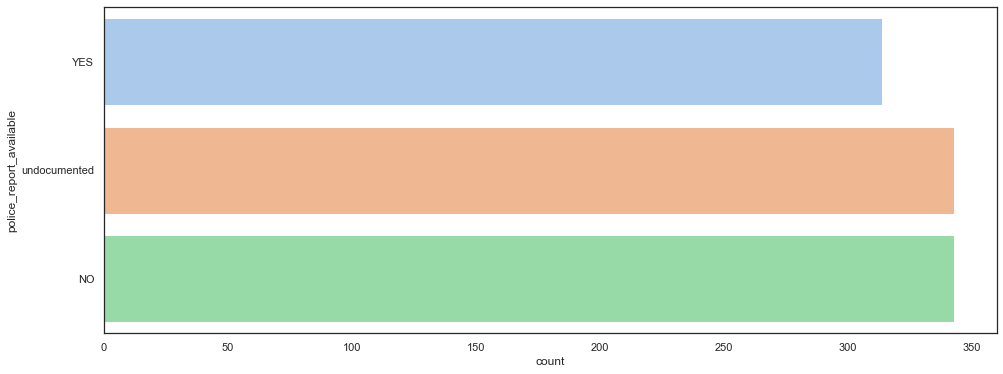

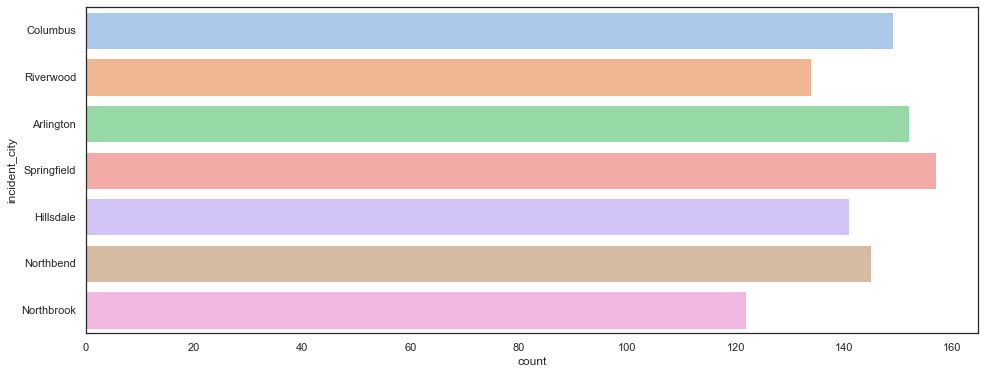

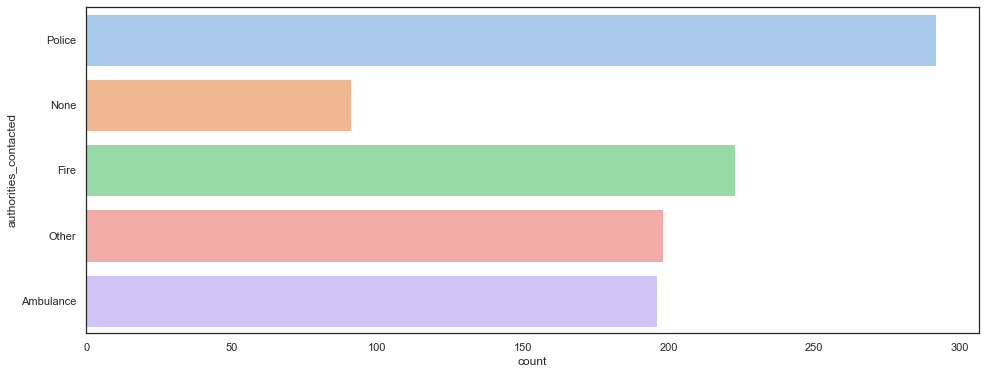

In [32]:
#countplot of discrete var , 

for i, name in enumerate(df[nom_var]):
    plt.figure(i,figsize=(16,6))
    sns.countplot(y=name, data=df, palette="pastel")

Nominal variables' counts were visualized with bar plots. I sum up some observations in point: 

- **Authorities_contacted:** Police are the most frequently contacted followed by the fire brigades. 
- **Auto_make:** apart from Honda (least), most are relatively even. 
- **Collision_type:** the distribution looks evenly spread across the categories. Most are rear collisions. Smallest groups are the undocumented collisions. we can explore which collisions will be the most expensive and have the most frauds.
- **Incident_city:** relatively even with Springfield and Arlington being the highest. 
- **Incident_type:** very few incidents are by theft/parked car. Most are by multivehicle collision and single vehicle collision. We can explore how claims and fraud differ across them. 
- **Property_damage:** relatively even but undocumented damage has the highest numbers

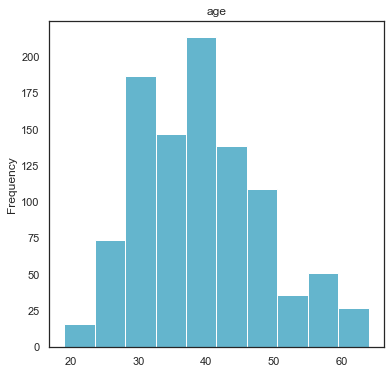

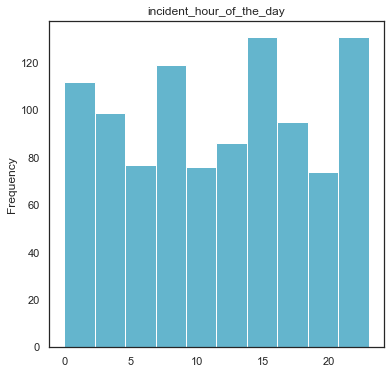

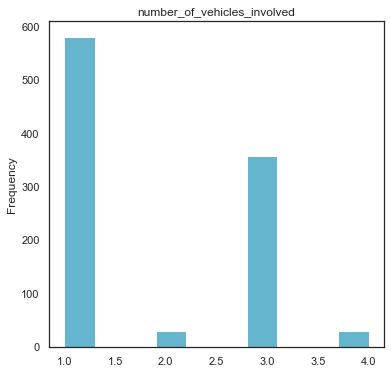

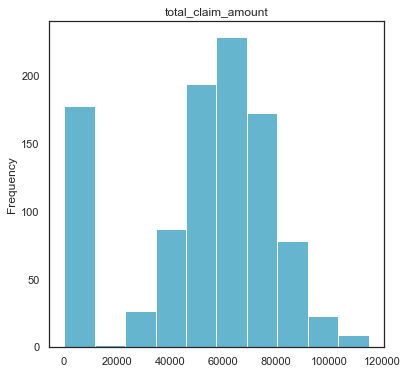

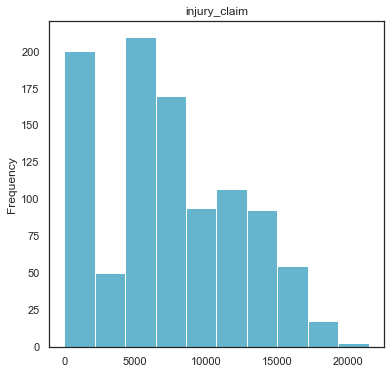

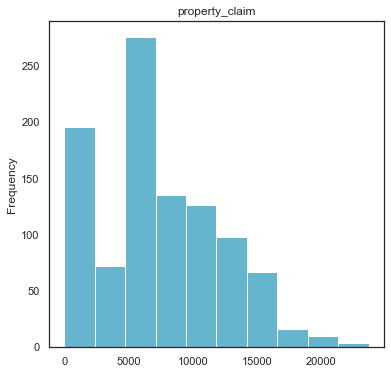

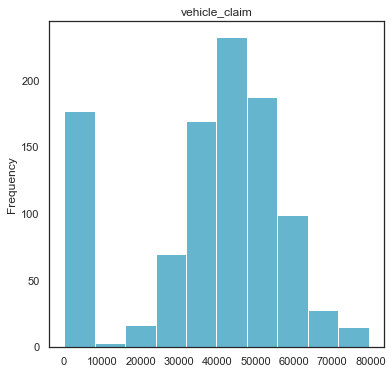

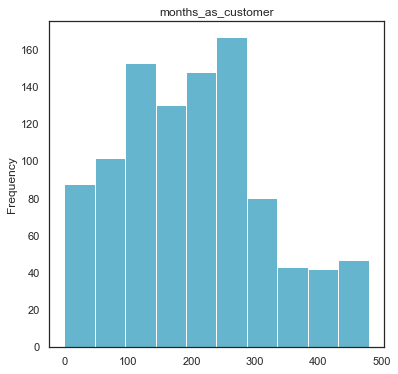

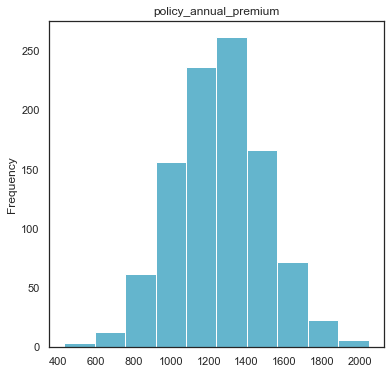

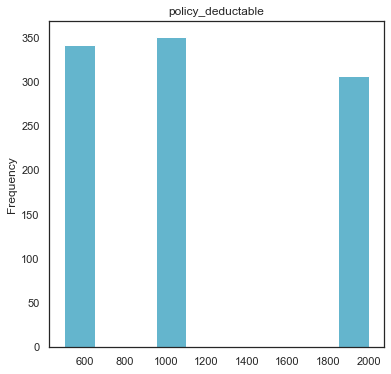

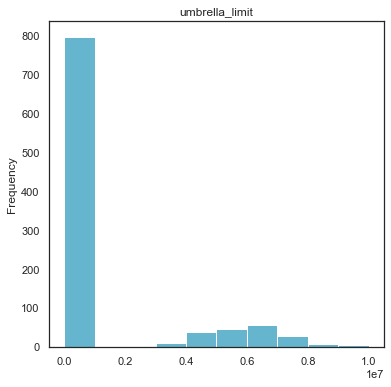

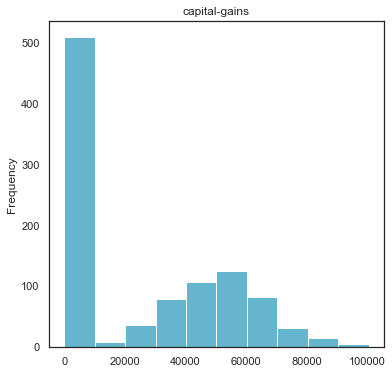

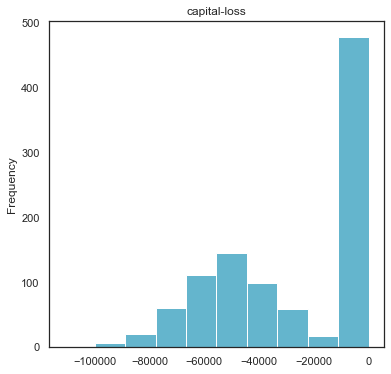

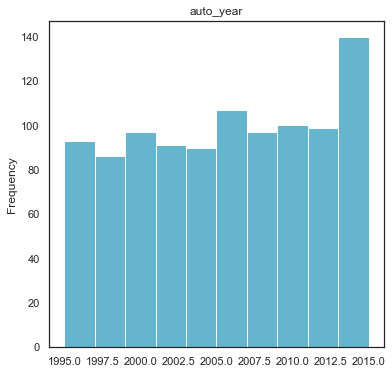

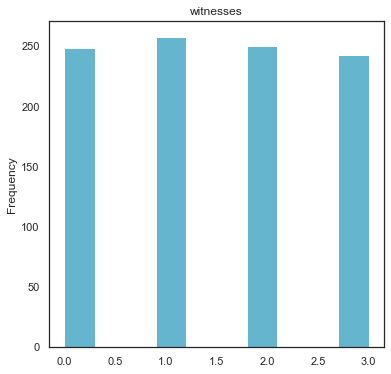

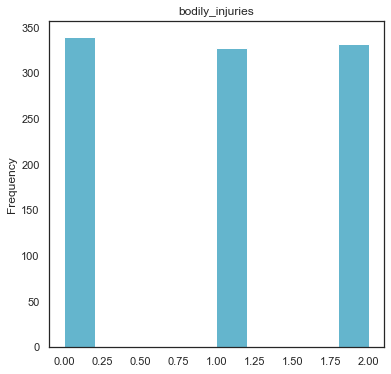

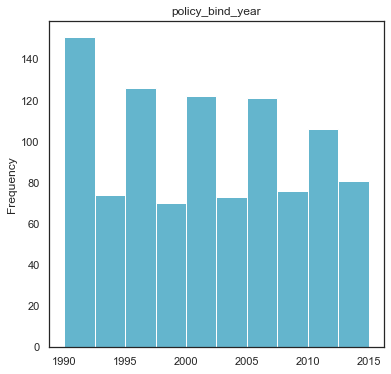

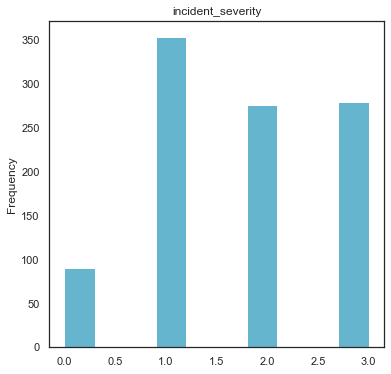

In [33]:
#distribution of ordinal and continuous variables

for i, name in enumerate(df[cont_var]):
    plt.figure(i,figsize=(6,6))
    df[name].plot(kind="hist", color="c", title=name)

Continuous variables' counts were visualized with bar plots. I sum up some observations in point: 

- **policy annual premium:** looks like a normal distribution.
- **policy bind years:** have staggering frequencies with some range of years more popular than others. This may be some auto market cycle. 1990 to 2992 is the highest.
- **capital gain and loss:** are mostly 0

### Visualizing variables against the DV

Counts of every variable split by the DV was plotted. Below are a few notable plots.

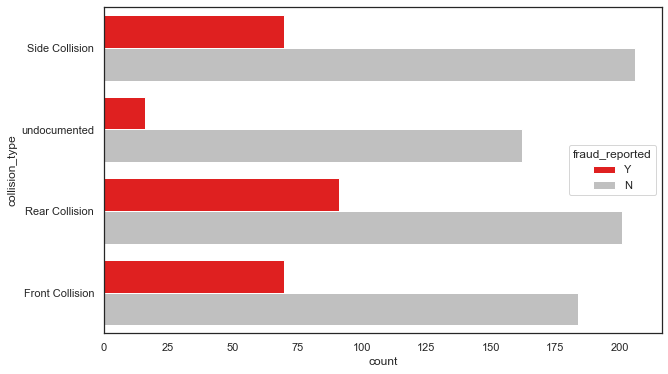

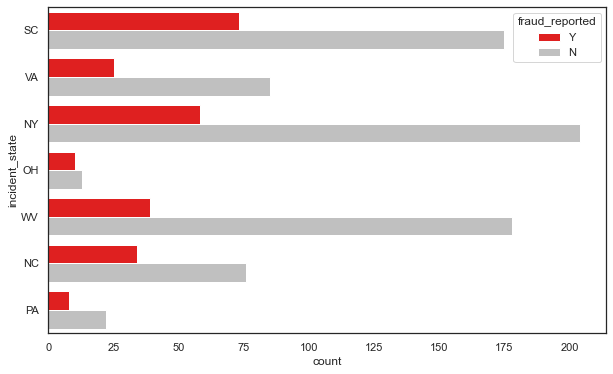

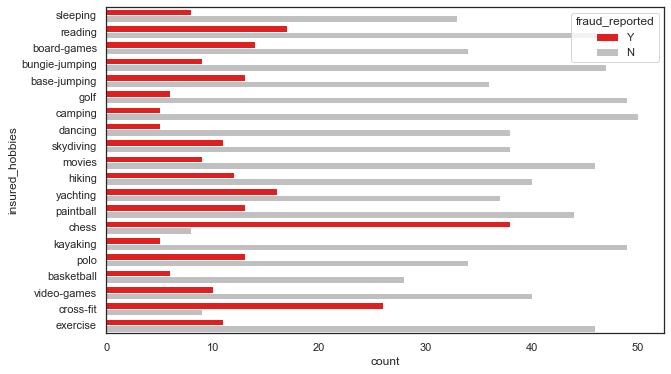

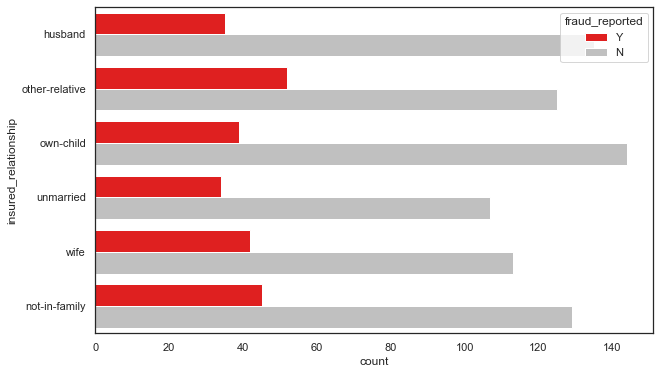

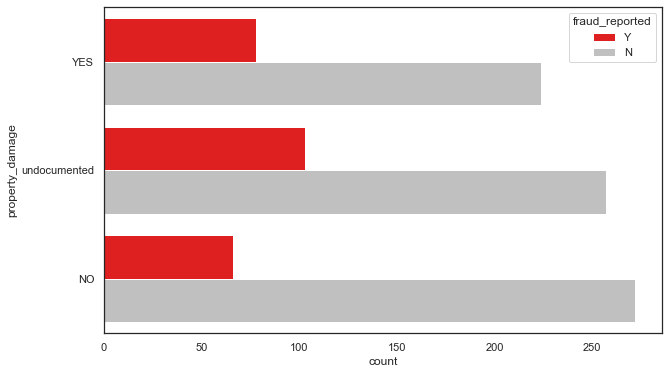

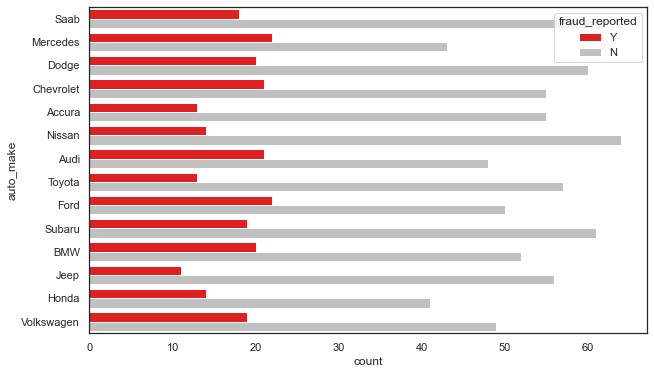

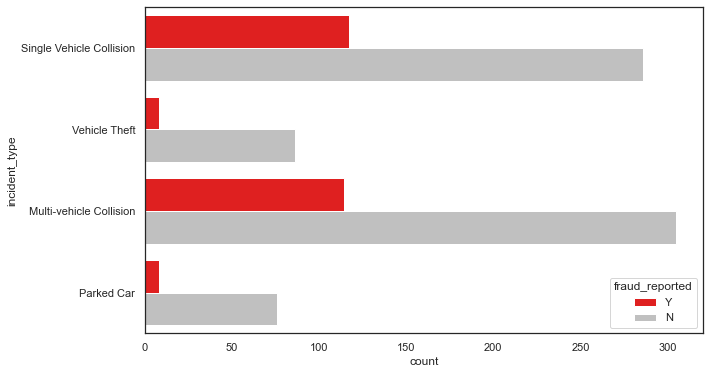

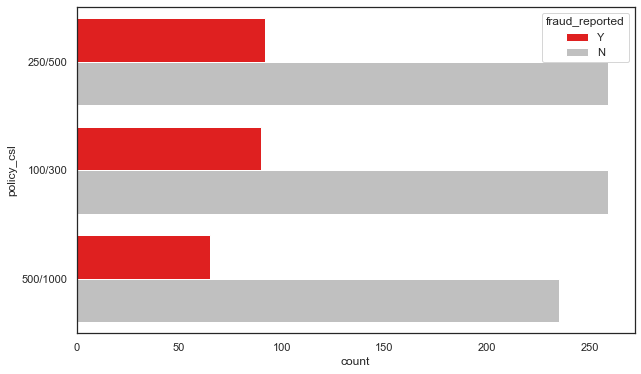

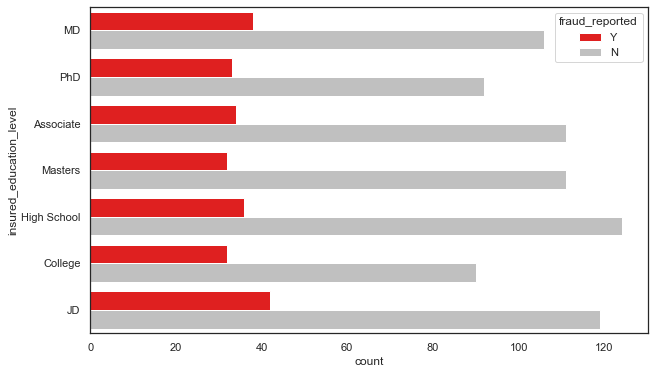

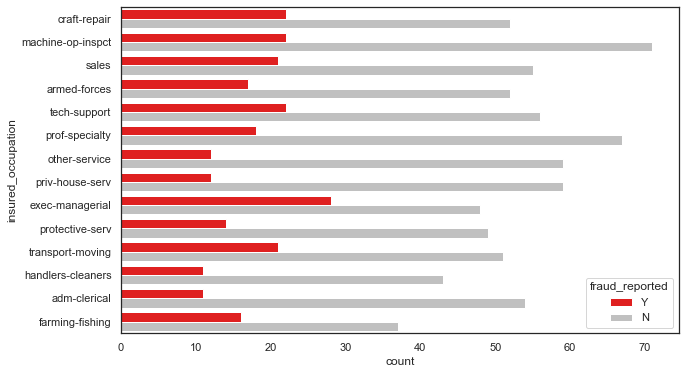

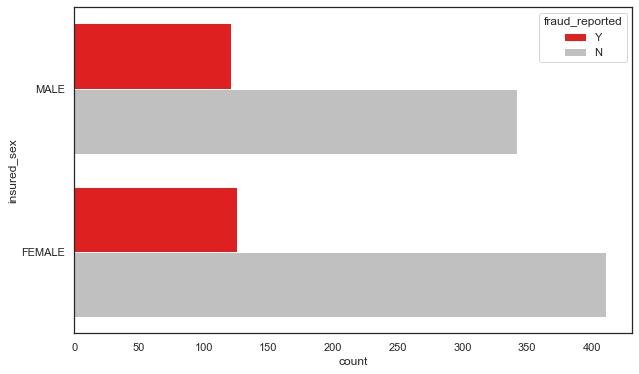

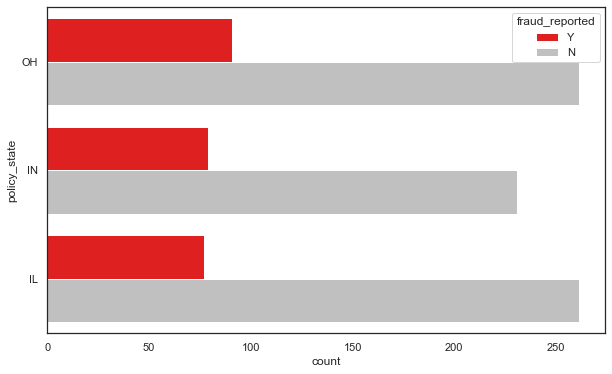

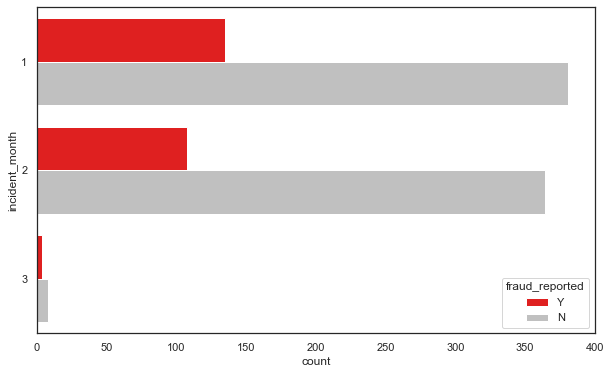

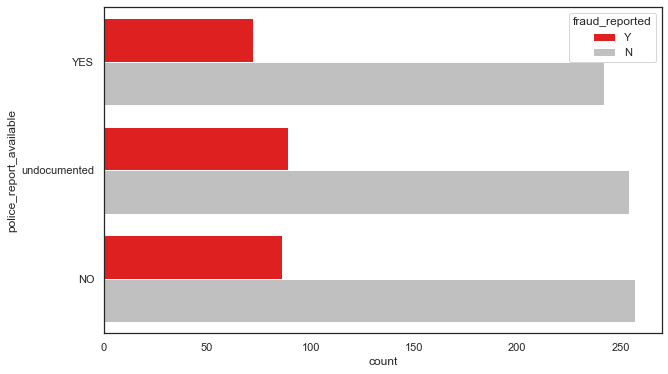

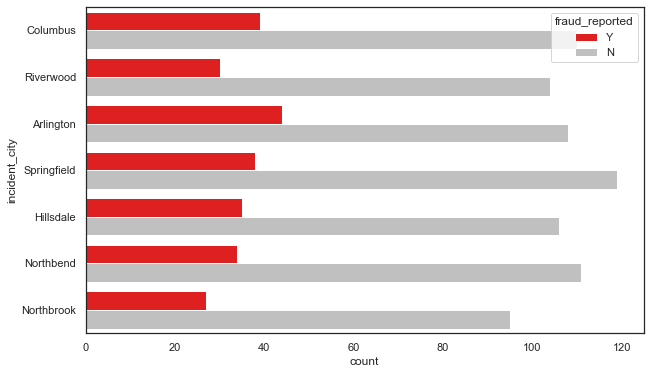

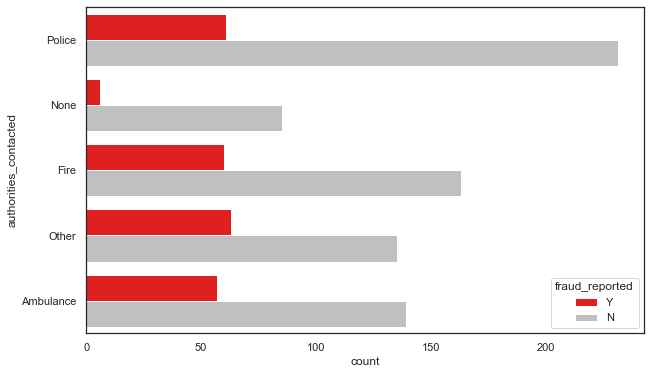

In [34]:
#each discrete var and fraud reported's dist

for i, name in enumerate(df[nom_var]):
    plt.figure(i,figsize=(10,6))
    sns.countplot(y=name, data=df, hue="fraud_reported", palette=['red','silver'])

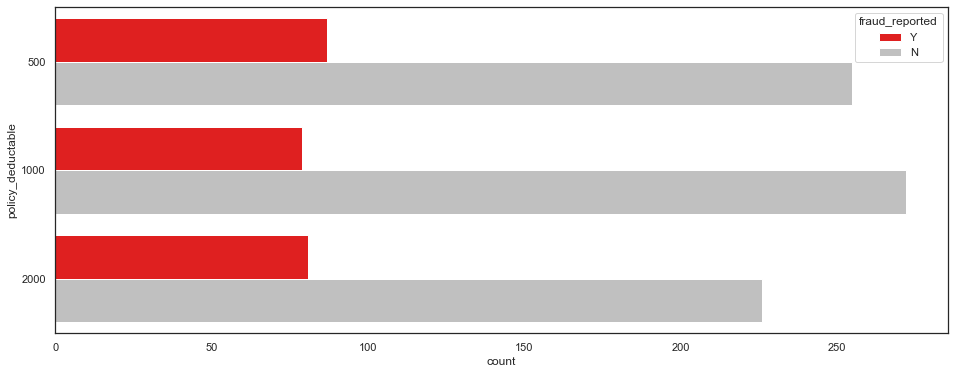

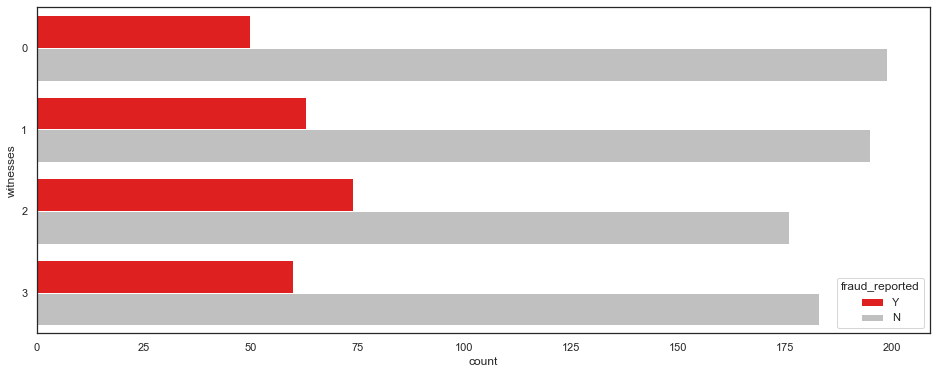

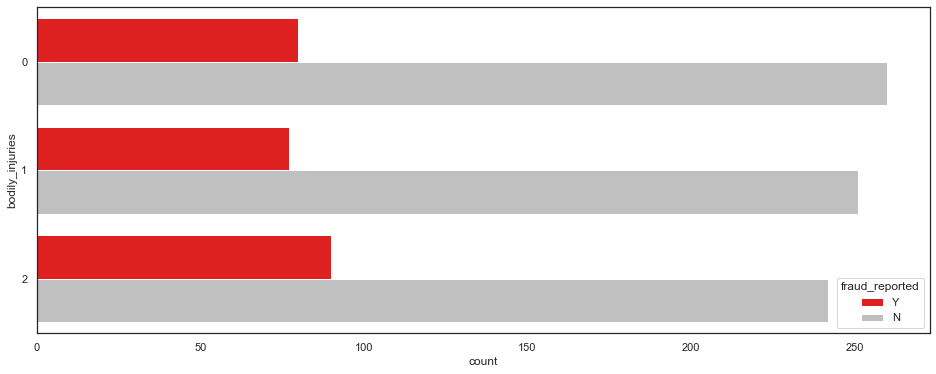

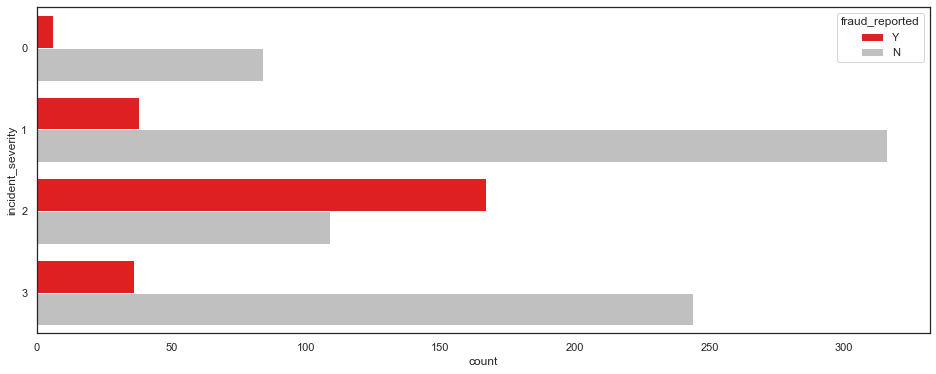

In [35]:
#each ordinal var and fraud reported's dist
#plt.style.use('dark_background')
#plt.style.use('default')


for i, name in enumerate(df[ord_var]):
    plt.figure(i,figsize=(16,6))
    sns.countplot(data=df, y=name, hue='fraud_reported', palette=['red','silver'])
    

<Figure size 1152x432 with 0 Axes>

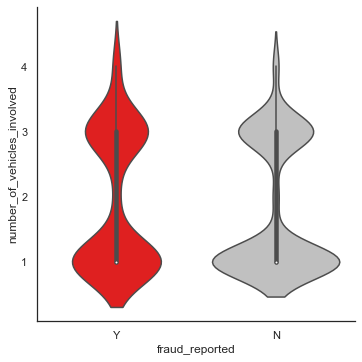

<Figure size 1152x432 with 0 Axes>

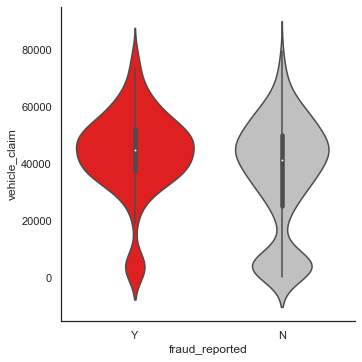

<Figure size 1152x432 with 0 Axes>

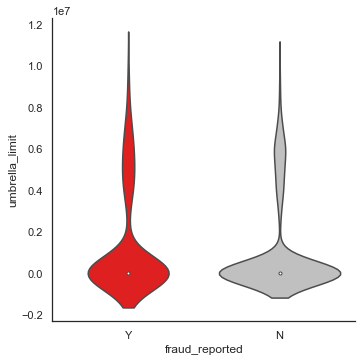

<Figure size 1152x432 with 0 Axes>

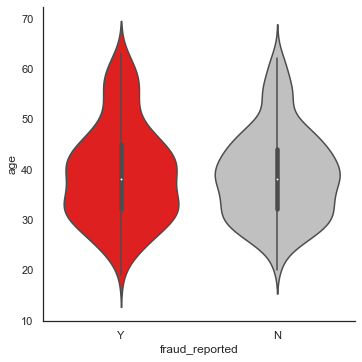

<Figure size 1152x432 with 0 Axes>

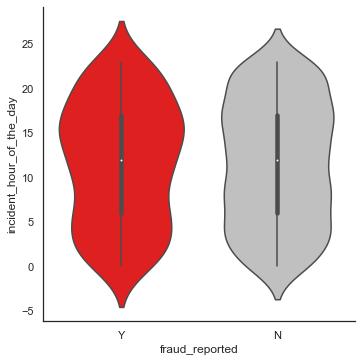

<Figure size 1152x432 with 0 Axes>

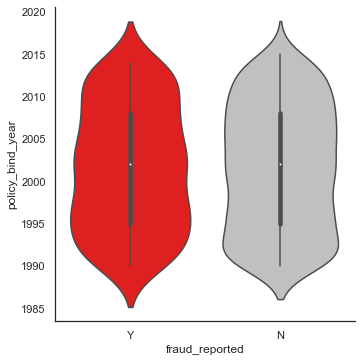

<Figure size 1152x432 with 0 Axes>

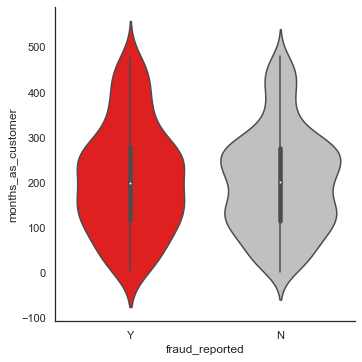

<Figure size 1152x432 with 0 Axes>

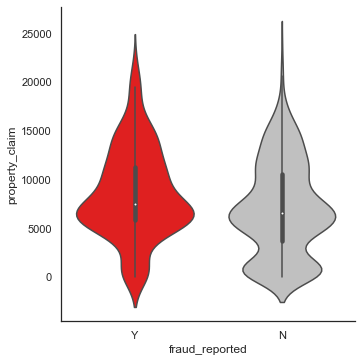

<Figure size 1152x432 with 0 Axes>

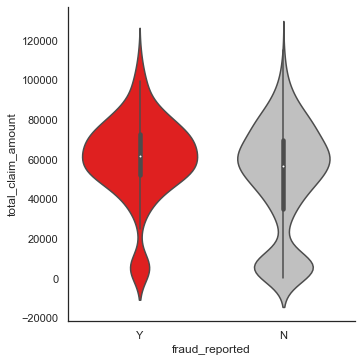

<Figure size 1152x432 with 0 Axes>

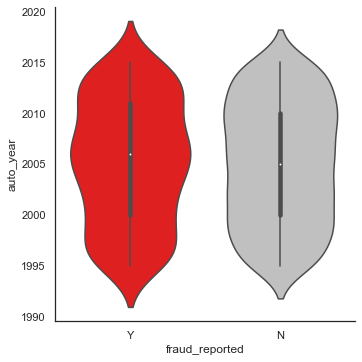

<Figure size 1152x432 with 0 Axes>

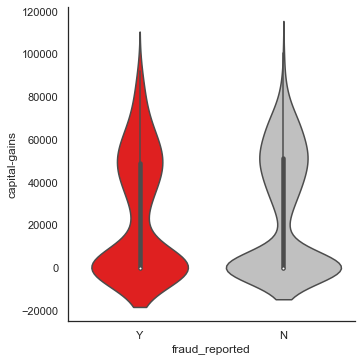

<Figure size 1152x432 with 0 Axes>

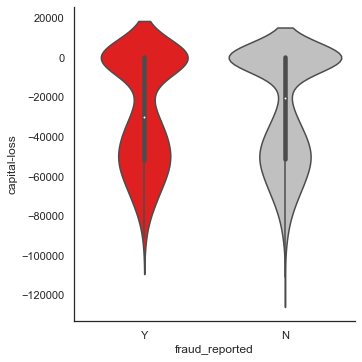

<Figure size 1152x432 with 0 Axes>

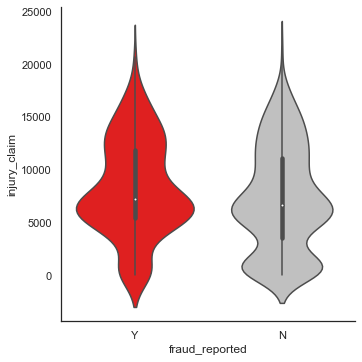

<Figure size 1152x432 with 0 Axes>

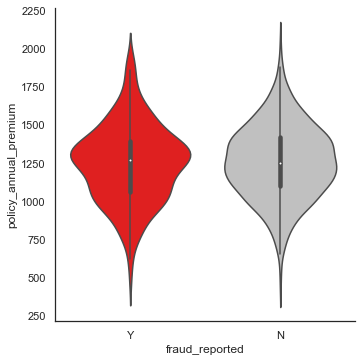

In [36]:
#each continous var and fraud reported's dist

for i, name in enumerate(df[quan_var]):
    plt.figure(i,figsize=(16,6))
    sns.catplot(data=df, x="fraud_reported", y=name, kind='violin', palette=['red','silver'])
    plt.show()

**Observations**

Little have I suspected that fraud differed across hobbies. It seems like chess players and cross-fitters have higher tendencies of fraud. I stopped to think if the sports develop one to be inclined to fraud or that people with tendencies are drawn to it.

<br>
<details><summary>Drop down to jump to that graph</summary>

![](images/fig3.png)
    
</details>

Major incident severity seems to have highest fraud cases that exceed non fraud cases.

<br>
<details><summary>Drop down to jump to that graph</summary>

![](images/fig4.PNG)
    
</details>

There seem to be more frauds than non-fraud claims along the mean of total claims. 

<br>
<details><summary>Drop down to jump to that graph</summary>

![](images/fig5.PNG)
    
</details>


### Additional visualization and observations

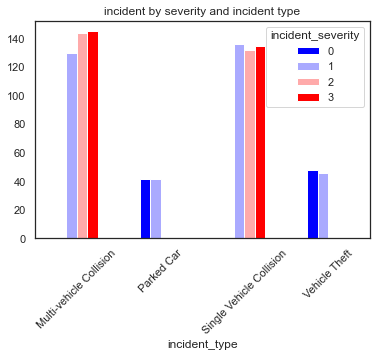

In [37]:
#cross tab of incident type and severity 
#more severe accidents seem to only be present with collision 

incident = pd.crosstab(df['incident_type'], df['incident_severity'])

incident.plot(kind='bar', colormap='bwr',figsize=(6,4))
plt.xticks(rotation=45)
plt.title("incident by severity and incident type");

More severe accidents seem to only be present with collision.

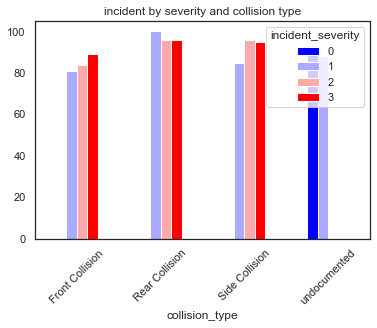

In [38]:
#undocumented collision types tend to be less severe

incident = pd.crosstab(df['collision_type'], df['incident_severity'])

incident.plot(kind='bar', colormap='bwr', figsize=(6,4))
plt.xticks(rotation=45)
plt.title("incident by severity and collision type");

Undocumented collision types tend to be less severe. Perhaps the drivers see no need to document since accidents are not major.

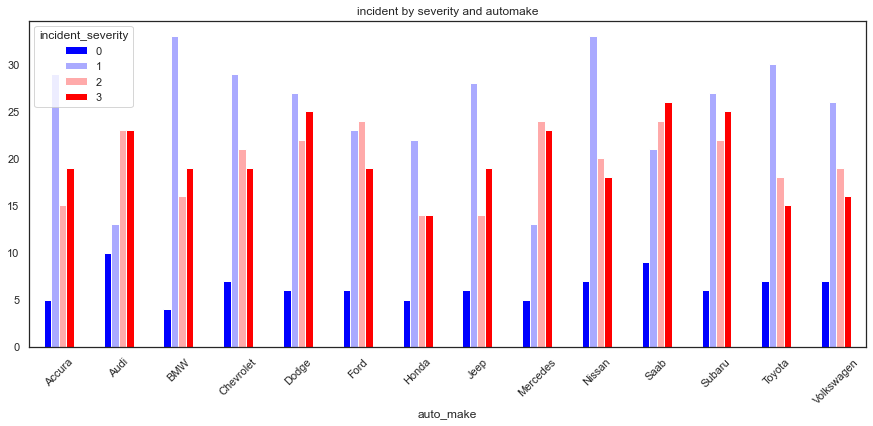

In [39]:
# seems like bmw and nissan gets a lot of minor accident
# fiercer cars like dodge, subaru, saab, merc get into mor severe accident

incident = pd.crosstab(df['auto_make'], df['incident_severity'])
incident.plot(kind='bar', colormap='bwr',figsize=(15,6))
plt.xticks(rotation=45)
plt.title("incident by severity and automake");

Seems like bmw and nissan gets a lot of minor accident
Fiercer cars like dodge, subaru, saab, merc get into mor severe accident

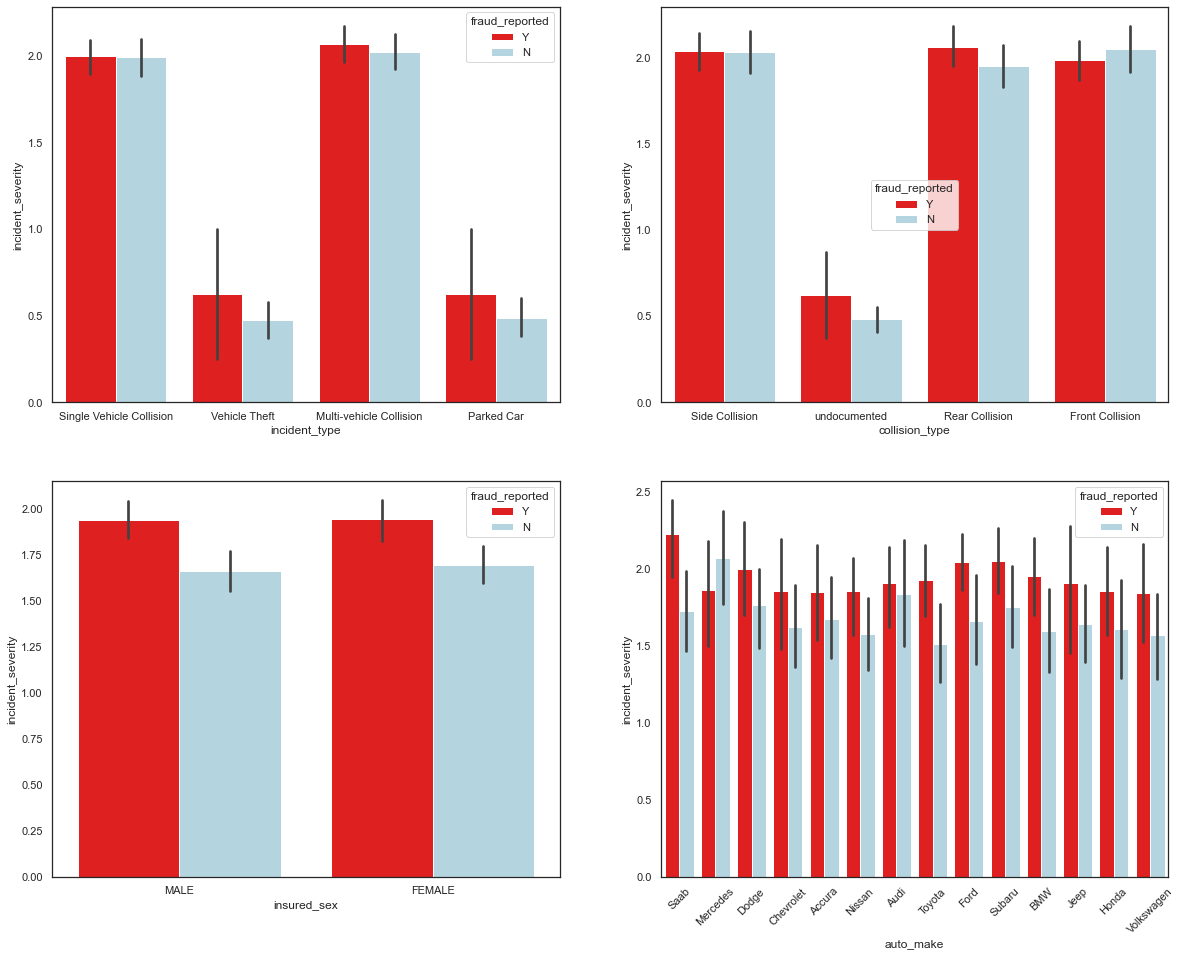

In [40]:
#severity and claims and fraud

fig, axes = plt.subplots(2,2, figsize=(20,16))

axes[0][0] = sns.barplot(x="incident_type", y="incident_severity",
                hue="fraud_reported", 
                data=df, palette=['red','lightblue'], ax=axes[0][0]);

axes[0][1] = sns.barplot(x="collision_type", y="incident_severity",
                hue="fraud_reported", 
                data=df, palette=['red','lightblue'], ax=axes[0][1]);

axes[1][0] = sns.barplot(x="insured_sex", y="incident_severity",
                hue="fraud_reported", 
                data=df, palette=['red','lightblue'], ax=axes[1][0]);

axes[1][1] = sns.barplot(x="auto_make", y="incident_severity",
                hue="fraud_reported", 
                data=df, palette=['red','lightblue'], ax=axes[1][1]);

plt.xticks(rotation=45);

# although theft and parked car are less severe, they have more fraud cases.. maybe acrimony and vengeful?
# rear collision and undocumented have more fraud.. again we see a trend that less severe accidetns more fraud (undoc)
# no obvious trend by sex 
#saab subaru ford seem to have more fraud cases

Although theft and parked car are less severe, they have more fraud cases. Perhaps due to acrimony and feelings of needing compensation for the perceived unfairness of an accident involving their vehicle while they were not involved or at fault. Rear collision and undocumented have more fraud. I see a trend that less severe accidents have more frauds. There is no obvious trend by sex. Saab, Subaru and Ford seem to have more fraud cases.

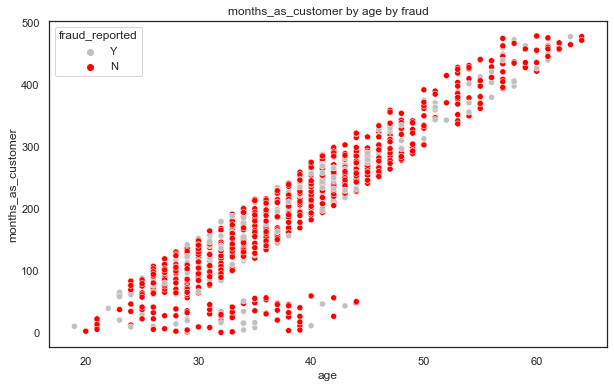

In [41]:
#try to see if there are any iteractions
#dont seem like it 
#a bunch of people across age are relatively new insurance  customers
#the rest are drivers that have insurance over the years.
#no clear pattern of interaction here

plt.figure(figsize=(10, 6))

sns.scatterplot(x="age", y="months_as_customer", 
            hue="fraud_reported", data=df,
            palette=['silver','red'])

plt.title("months_as_customer by age by fraud");

I tried to see if there are any interactions between months as customer and age on fraud but there don’t seem to be. From the graph we can see that a group of people across age are relatively new insurance customers while the rest are drivers that have insurance over the years.

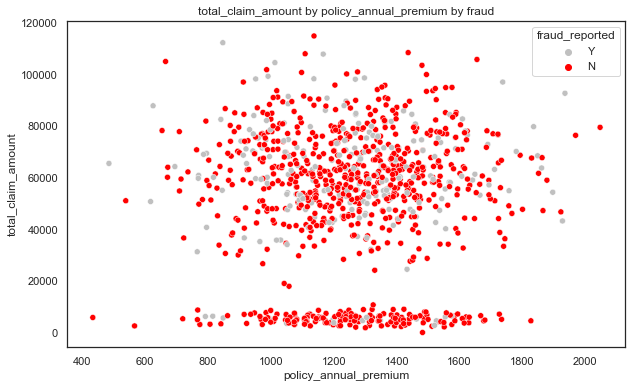

In [42]:
#no clear pattern but seems like claims close to 0 has most frauds

plt.figure(figsize=(10, 6))

sns.scatterplot(x="policy_annual_premium", y="total_claim_amount", 
            hue="fraud_reported", data=df,
            palette=['silver','red'])

plt.title("total_claim_amount by policy_annual_premium by fraud");

When plotted total claim amount and policy annual premium and fraud as a scatter plot, there were no clear patterns, but I noticed that there seem to be a high density of frauds at lower total claim amounts (lower than $20, 000).

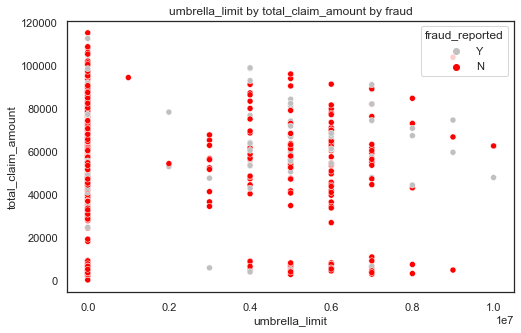

In [43]:
#seems like no umbrella limit more fraud?
#this people may have little to lose which is why they dont perchase umbrella 
#inversely, those who purchase have a lot of asset and a lot to lose so may be less prone to fraud?

plt.figure(figsize=(8, 5))

sns.scatterplot(x="umbrella_limit", y="total_claim_amount", 
            hue="fraud_reported", data=df,
            palette=['silver','red'])

plt.title("umbrella_limit by total_claim_amount by fraud");

When I plotted seems like no umbrella limit with total claim amount, I noticed that those without umbrella limit have more density of fraud? This people may have little to lose which is why they don't purchase umbrella. Inversely, those who purchase have a lot of asset and a lot to lose so may be less prone to fraud.

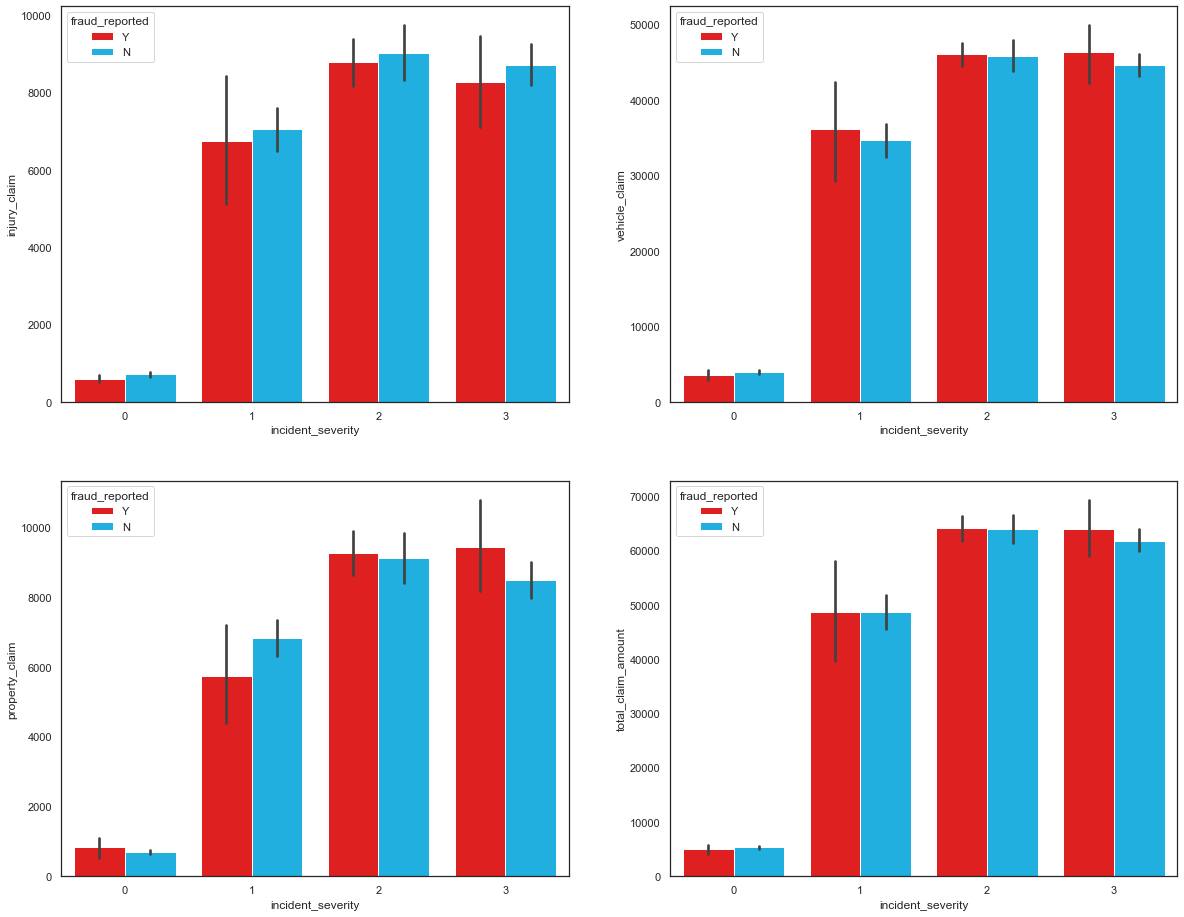

In [44]:
#severity and claims and fraud

fig, axes = plt.subplots(2,2, figsize=(20,16))

axes[0][0] = sns.barplot(x="incident_severity", y="injury_claim",
                hue="fraud_reported", 
                data=df, palette=['red','deepskyblue'], ax=axes[0][0]);

axes[0][1] = sns.barplot(x="incident_severity", y="vehicle_claim",
                hue="fraud_reported", 
                data=df, palette=['red','deepskyblue'], ax=axes[0][1]);

axes[1][0] = sns.barplot(x="incident_severity", y="property_claim",
                hue="fraud_reported", 
                data=df, palette=['red','deepskyblue'], ax=axes[1][0]);

axes[1][1] = sns.barplot(x="incident_severity", y="total_claim_amount",
                hue="fraud_reported", 
                data=df, palette=['red','deepskyblue'], ax=axes[1][1]);

# vehicle claims and property claims have more frauds than injury claims
# does someone act more honestly after injury??

Next, I looked at different types of claims and incident severity and frauds. Vehicle claims and property claims have more frauds than injury claims. Perhaps damage of vehicles and property causes more perceived unfairness. Trend of fraud is less obvious in total claims against incident severity as after summing and aggregating across different types of claims, the variances cancel out each other.

### Losses by claims

Here, I define loss as simply money going out from the insurance company.

In [45]:
#create a variable that measure how much claims - how much premiums was paid by a client to indeicate a loss/profit

df['loss_by_claims'] = df['total_claim_amount'] - (df['policy_annual_premium'] * (2015 - df['policy_bind_year']))

In [46]:
df.groupby('fraud_reported')['loss_by_claims'].sum()

fraud_reported
N    25126613.43
Y    10806751.60
Name: loss_by_claims, dtype: float64

In [47]:
df.groupby('fraud_reported')['loss_by_claims'].mean()

fraud_reported
N    33368.676534
Y    43752.030769
Name: loss_by_claims, dtype: float64

In [48]:
43752.030769-33368.676534

10383.354234999999

## Preprocessing
The DV, fraud_reported was coded 1 for fraud and 0 for non-fraud. 

Six interaction terms were created. Interaction between property claim amount and incident severity, vehicle claim amount and incident severity, injury claim amount and incident severity, total claim amount and incident severity, policy annual premium and total claim amount, umbrella limit and total claim amount.

Nominal variables were one-hot encoded, and the data set was split into 75% train and 25% test set, stratified on fraud reported. 

In [49]:
#DV numerical code
df['fraud_reported'] = df['fraud_reported'].map({"Y":1, "N":0})
df['fraud_reported']

0      1
1      1
2      0
3      1
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: fraud_reported, Length: 1000, dtype: int64

In [50]:
df['insured_sex'] = df['insured_sex'].map({"FEMALE":0,"MALE":1})

In [51]:
df['capital-loss'].head()

0        0
1        0
2        0
3   -62400
4   -46000
Name: capital-loss, dtype: int64

In [52]:
df['capital-loss']=df['capital-loss']*(-1)

In [53]:
df['capital-loss'].head()

0        0
1        0
2        0
3    62400
4    46000
Name: capital-loss, dtype: int64

In [54]:
df['capital-loss'].max()

111100

In [55]:
#check that they are coded

df['pclaim_severity_int'] = df['property_claim']*df['incident_severity']
df['vclaim_severity_int'] = df['vehicle_claim']*df['incident_severity']
df['iclaim_severity_int'] = df['injury_claim']*df['incident_severity']
df['tclaim_severity_int'] = df['total_claim_amount']*df['incident_severity']

df['prem_claim_int'] = df['policy_annual_premium']*df['total_claim_amount']
df['umlimit_tclaim_int'] = df['umbrella_limit']*df['total_claim_amount']

#### Dummy coding

In [56]:
rem = ['insured_sex','incident_month']
dum_list = [e for e in nom_var if e not in rem]
len(dum_list)

14

In [57]:
dum = pd.get_dummies(df[dum_list], drop_first=True)
dum.head()

,collision_type_Rear Collision,collision_type_Side Collision,collision_type_undocumented,incident_state_NY,incident_state_OH,incident_state_PA,incident_state_SC,incident_state_VA,incident_state_WV,insured_hobbies_basketball,insured_hobbies_board-games,insured_hobbies_bungie-jumping,insured_hobbies_camping,insured_hobbies_chess,insured_hobbies_cross-fit,insured_hobbies_dancing,insured_hobbies_exercise,insured_hobbies_golf,insured_hobbies_hiking,insured_hobbies_kayaking,insured_hobbies_movies,insured_hobbies_paintball,insured_hobbies_polo,insured_hobbies_reading,insured_hobbies_skydiving,insured_hobbies_sleeping,insured_hobbies_video-games,insured_hobbies_yachting,insured_relationship_not-in-family,insured_relationship_other-relative,insured_relationship_own-child,insured_relationship_unmarried,insured_relationship_wife,property_damage_YES,property_damage_undocumented,auto_make_Audi,auto_make_BMW,auto_make_Chevrolet,auto_make_Dodge,auto_make_Ford,auto_make_Honda,auto_make_Jeep,auto_make_Mercedes,auto_make_Nissan,auto_make_Saab,auto_make_Subaru,auto_make_Toyota,auto_make_Volkswagen,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,policy_csl_250/500,policy_csl_500/1000,insured_education_level_College,insured_education_level_High School,insured_education_level_JD,insured_education_level_MD,insured_education_level_Masters,insured_education_level_PhD,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,insured_occupation_protective-serv,insured_occupation_sales,insured_occupation_tech-support,insured_occupation_transport-moving,policy_state_IN,policy_state_OH,police_report_available_YES,police_report_available_undocumented,incident_city_Columbus,incident_city_Hillsdale,incident_city_Northbend,incident_city_Northbrook,incident_city_Riverwood,incident_city_Springfield,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police
0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1
2,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [58]:
dum.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df_dummied = pd.concat([df, dum], axis=1)

In [59]:
df_dummied.drop(nom_var, axis=1, inplace=True)

In [60]:
df_dummied.head()

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_severity,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,fraud_reported,policy_bind_year,loss_by_claims,pclaim_severity_int,vclaim_severity_int,iclaim_severity_int,tclaim_severity_int,prem_claim_int,umlimit_tclaim_int,collision_type_Rear Collision,collision_type_Side Collision,collision_type_undocumented,incident_state_NY,incident_state_OH,incident_state_PA,incident_state_SC,incident_state_VA,incident_state_WV,insured_hobbies_basketball,insured_hobbies_board-games,insured_hobbies_bungie-jumping,insured_hobbies_camping,insured_hobbies_chess,insured_hobbies_cross-fit,insured_hobbies_dancing,insured_hobbies_exercise,insured_hobbies_golf,insured_hobbies_hiking,insured_hobbies_kayaking,insured_hobbies_movies,insured_hobbies_paintball,insured_hobbies_polo,insured_hobbies_reading,insured_hobbies_skydiving,insured_hobbies_sleeping,insured_hobbies_video-games,insured_hobbies_yachting,insured_relationship_not-in-family,insured_relationship_other-relative,insured_relationship_own-child,insured_relationship_unmarried,insured_relationship_wife,property_damage_YES,property_damage_undocumented,auto_make_Audi,auto_make_BMW,auto_make_Chevrolet,auto_make_Dodge,auto_make_Ford,auto_make_Honda,auto_make_Jeep,auto_make_Mercedes,auto_make_Nissan,auto_make_Saab,auto_make_Subaru,auto_make_Toyota,auto_make_Volkswagen,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,policy_csl_250/500,policy_csl_500/1000,insured_education_level_College,insured_education_level_High School,insured_education_level_JD,insured_education_level_MD,insured_education_level_Masters,insured_education_level_PhD,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,insured_occupation_protective-serv,insured_occupation_sales,insured_occupation_tech-support,insured_occupation_transport-moving,policy_state_IN,policy_state_OH,police_report_available_YES,police_report_available_undocumented,incident_city_Columbus,incident_city_Hillsdale,incident_city_Northbend,incident_city_Northbrook,incident_city_Riverwood,incident_city_Springfield,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police
0,328,48,1000,1406.91,0,53300,0,2,5,1,1,2,71610,6510,13020,52080,2004,1,2014,70203.09,26040,104160,13020,143220,100748825.1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1
1,228,42,2000,1197.22,5000000,0,0,1,8,1,0,0,5070,780,780,3510,2007,1,2006,-5704.98,780,3510,780,5070,6069905.4,25350000000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1
2,134,29,2000,1413.14,5000000,35100,0,1,7,3,2,3,34650,7700,3850,23100,2007,0,2000,13452.90,3850,23100,7700,34650,48965301.0,173250000000,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,256,41,2000,1415.74,6000000,48900,62400,2,5,1,1,2,63400,6340,6340,50720,2014,1,1990,28006.50,12680,101440,12680,126800,89757916.0,380400000000,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,228,44,1000,1583.91,6000000,66000,46000,1,20,1,0,1,6500,1300,650,4550,2009,0,2014,4916.09,650,4550,1300,6500,10295415.0,39000000000,0,0,1,1,0,0,

In [61]:
df_dummied.isnull().sum().any()

False

In [62]:
df_dummied['umbrella_limit'].sort_values(ascending=True)

0             0
622           0
623           0
624           0
625           0
         ...   
700     9000000
88      9000000
975     9000000
115    10000000
430    10000000
Name: umbrella_limit, Length: 1000, dtype: int64

In [63]:
dd = df_dummied.describe()
dd.loc['min']

months_as_customer                0.00
age                              19.00
policy_deductable               500.00
policy_annual_premium           433.33
umbrella_limit                    0.00
                                 ...  
incident_city_Springfield         0.00
authorities_contacted_Fire        0.00
authorities_contacted_None        0.00
authorities_contacted_Other       0.00
authorities_contacted_Police      0.00
Name: min, Length: 112, dtype: float64

#### Train Test Split

In [64]:
x = df_dummied.drop('fraud_reported', axis=1)
y = df_dummied['fraud_reported']

In [65]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

In [66]:
#baseline accuracy = 75.2%

y_test.value_counts(normalize=True)

0    0.752
1    0.248
Name: fraud_reported, dtype: float64

In [67]:
y_test.value_counts()

0    188
1     62
Name: fraud_reported, dtype: int64

## Baseline Score
As our dataset is imbalance, accuracy is not a good measure of success. A high accuracy can be achieved by a poor model that only selects the majority class, hence, not detecting and measuring the accuracy of classifying the class of interest. In fact, predicting only the majority class will give an accuracy of 75%, specificity of 100% but a sensitivity of 0%.

## Modeling 

Five different classifiers were used in this project: 
- logistic regression
- K-nearest neighbours
- Random forest
- XGBoost 
- AdaBoost 

Hyperparameter tuning and selection was done for all the models using RandomizedSearch. Due to the number of parameters and models that were ran, RandomizedSearch is a faster more efficient choice as compared to gridsearch.

<br>
After a 10-fold RandomizedSearchCV, the model with its selected hyperparameters were fitted on the training set. 

Mean accuracy scores for the best estimators of the RandomizedSearchCV, accuracy scores on the training set and accuracy scores on the test set was computed. Then, the sensitivity, specificity, precision, F1 score and ROC AUC scores were computed. 

<br>
This section discusses how different blocks of models were ran. Evaluation of the models will be the evaluation section.

### Model with class weighting and hyperparameter tuning

The five classifiers as per stated above were ran with hyperparameter tuning. Models that had option for class weighting had class weighting as one of the hyperparameters in this block of models. That is, the RandomizedSearch will test a weighted and non-weighted model to see which performed better. 

A best practice for using the class weighting is to use the inverse of the class distribution present in the training dataset. For example, the class distribution of the test dataset is a 1:100 ratio for the minority class to the majority class. The inversion of this ratio could be used with 1 for the majority class and 100 for the minority class; for example:{0:1.0, 1:100.0}. In our case, class weights were {0:0.246667, 1:0.75333}. In XGBoost, class weights are defined differently. XGBoost uses scale positive weight which is the total negative examples divided by the total positive examples. For an imbalanced binary classification dataset, the negative class refers to the majority class (class 0) and the positive class refers to the minority class (class 1). The scaled positive weight in this analysis is 3.054.

### Logistic regression

In [68]:
y_train.value_counts(normalize=True)

0    0.753333
1    0.246667
Name: fraud_reported, dtype: float64

In [69]:
#ransearch log reg

lr = LogisticRegression(max_iter=200)

weights = np.linspace(0.0,0.99,200)

lr_values = {
    'class_weight':[{0:x, 1:1.0-x} for x in weights]
    }

    
rs_lr = RandomizedSearchCV(lr, lr_values, cv=10, n_jobs = -1, random_state=42)
rs_lr.fit(x_train, y_train, )
print(rs_lr.best_params_)

{'class_weight': {0: 0.47261306532663316, 1: 0.5273869346733668}}


### KNN

In [70]:
# knn = KNeighborsClassifier()
# ss = StandardScaler()

knn_pipe = Pipeline([
    ("ss", StandardScaler()),
    ("knn", KNeighborsClassifier(n_jobs=-1))])

knn_values = {'knn__n_neighbors':[3,5,7,9,11],
              'knn__weights':['uniform', 'distance'],
              'knn__metric':['minkowski','euclidean','manhattan'],
              'knn__algorithm':['auto', 'ball_tree','kd_tree','brute'],
              'knn__leaf_size':[1,2,3,4,5,6,7,8,9,10]
             }

    
rs_knn = RandomizedSearchCV(knn_pipe, knn_values, cv=10, n_jobs = -1, random_state=42)
rs_knn.fit(x_train, y_train)
print(rs_knn.best_params_)

{'knn__weights': 'distance', 'knn__n_neighbors': 7, 'knn__metric': 'euclidean', 'knn__leaf_size': 7, 'knn__algorithm': 'brute'}


### Random forest

In [71]:
rf = RandomForestClassifier(n_jobs=-1)

rf_values = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'min_samples_leaf': [1, 2, 3, 4, 5],
             'min_samples_split': [2, 5, 7, 9, 11],
             'max_features': ['auto', 'sqrt'],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             'class_weight':[{0:0.246667, 1:0.75333},None]
              }


    
rs_rf = RandomizedSearchCV(rf, rf_values, cv=10, n_jobs = -1, random_state=42)
rs_rf.fit(x_train, y_train)
print(rs_rf.best_params_)

{'n_estimators': 350, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'class_weight': {0: 0.246667, 1: 0.75333}}


### XGBoost

scale_pos_weight = total_negative_examples / total_positive_examples

For an imbalanced binary classification dataset, the negative class refers to majority class (class 0) and the positive class refers to the minority class (class 1).

In [72]:
y_train.value_counts()

0    565
1    185
Name: fraud_reported, dtype: int64

In [73]:
#scaled positive weight
565/185

3.054054054054054

In [74]:
xg = XGBClassifier(booster='gbtree', n_jobs=-1)

xg_values = {'max_depth': [3, 4, 5, 6],
             'eta': [0.05, 0.1, 0.15, 0.3],
             'reg_lambda': [0.01, 0.05, 0.1, 0.5, 1],
             'reg_alpha': [0.01, 0.05, 0.1, 0.5, 1],
             'gamma': [0, 1, 2, 3],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             'scale_pos_weight':[1, 3.054054054054054],
              }
    
rs_xg = RandomizedSearchCV(xg, xg_values, cv=10, n_jobs = -1, random_state=42)
rs_xg.fit(x_train, y_train)
print(rs_xg.best_params_)

C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'scale_pos_weight': 3.054054054054054, 'reg_lambda': 0.1, 'reg_alpha': 0.05, 'n_estimators': 550, 'max_depth': 6, 'gamma': 3, 'eta': 0.05}


### AdaBoost

In [75]:
ab = AdaBoostClassifier()

ab_values = {'n_estimators':[50,100,150,200,250,300,350,400,450,500,550,600],
            'learning_rate':[0.05,0.1,0.3,0.5]
              }


    
rs_ab = RandomizedSearchCV(ab, ab_values, cv=10, n_jobs = -1, random_state=42)
rs_ab.fit(x_train, y_train)
print(rs_rf.best_params_)

{'n_estimators': 350, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'class_weight': {0: 0.246667, 1: 0.75333}}


In [76]:
#function to use for scoring 

def scores(t, name):
    print (name, 'classification metric')
    print("CV scores:", round(t.best_score_,3))
    print("train score:", round(t.score(x_train, y_train),3))
    print("test score:", round(t.score(x_test, y_test),3))

    #Evaluation metrics
    predictions = t.predict(x_test)

    TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

    sensi = TP/(TP + FN)
    preci = TP/(TP + FP)
    f1= 2*(preci*sensi)/(preci+sensi)

    print(f'Sensitivity: {round(sensi,3)}')
    print(f'Precision: {round(preci,3)}')
    print(f'F1: {round(f1,3)}')

    pred_proba = [i[1] for i in t.predict_proba(x_test)]
    auc_score = roc_auc_score(y_test, pred_proba)
    print('ROC AUC Score:', round(auc_score,3))
    return '_______________________'

In [77]:
from sklearn.metrics import confusion_matrix
classifiers={'logreg':rs_lr, 'knn':rs_knn, 'Ranfor':rs_rf, 
             'XGB':rs_xg, 'AdaBoost':rs_ab}

for key, value in classifiers.items(): 
    print(scores(value,key))
    print(" ")
    


logreg classification metric
CV scores: 0.753
train score: 0.749
test score: 0.752
Sensitivity: 0.032
Precision: 0.5
F1: 0.061
ROC AUC Score: 0.5
_______________________
 
knn classification metric
CV scores: 0.772
train score: 1.0
test score: 0.74
Sensitivity: 0.161
Precision: 0.435
F1: 0.235
ROC AUC Score: 0.666
_______________________
 
Ranfor classification metric
CV scores: 0.795
train score: 0.98
test score: 0.796
Sensitivity: 0.565
Precision: 0.593
F1: 0.579
ROC AUC Score: 0.824
_______________________
 
XGB classification metric
CV scores: 0.835
train score: 0.969
test score: 0.844
Sensitivity: 0.806
Precision: 0.649
F1: 0.719
ROC AUC Score: 0.842
_______________________
 
AdaBoost classification metric
CV scores: 0.811
train score: 0.896
test score: 0.776
Sensitivity: 0.419
Precision: 0.565
F1: 0.481
ROC AUC Score: 0.829
_______________________
 


## Evaluation 

Cross validation accuracy scores, accuracy scores on training set, accuracy scores on test set, sensitivity, specificity, precision, F1 score and ROC AUC was computed and printed as shown in the table below. 

**Observations:**

- 

![](images/model_evaluation.jpg)



## Final Model: Weighted XGBoost

The final fitted model is the weighted XGBoost on the dataset with no oversampling. The best estimators of the model are as follows:

- Scale_pos_weight: 3.054054054054054, 
- Reg_lambda (L2 regularization weight): 0.1, 
- Reg_alpha (L1 regularization weight): 0.05, 
- N_estimators: 550, 
- Max_depth: 6, 
- Gamma: 3, 
- Eta: 0.05

In [78]:
x = df_dummied.drop('fraud_reported', axis=1)
y = df_dummied['fraud_reported']

In [79]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

In [80]:
print("Final Model: Weighted XGBoost")
print("train score:", round(rs_xg.best_estimator_.score(x_train, y_train),3))
print("test score:", round(rs_xg.best_estimator_.score(x_test, y_test),3))


Final Model: Weighted XGBoost
train score: 0.969
test score: 0.844


### Final fitted model's performance

The model had a training accuracy score of 0.967 and a test accuracy of 0.844. The high accuracy score hint of a low bias (it is only a hint as accuracy is not a good measure of bias in imbalance class problems).
An accuracy score difference of 0.123 between train and test is relatively small. Thus, this model can be said to have low variance and is generalizable on unseen data.

In [81]:
#classification report

predictions = rs_xg.best_estimator_.predict(x_test)
print(classification_report(y_test, predictions, target_names=['Not Fraud',"Fraud"]))

              precision    recall  f1-score   support

   Not Fraud       0.93      0.86      0.89       188
       Fraud       0.65      0.81      0.72        62

    accuracy                           0.84       250
   macro avg       0.79      0.83      0.81       250
weighted avg       0.86      0.84      0.85       250



The ROC curve below summarizes how well our model is at balancing between the true positive rate(sensitivity) and the false positive rate(1-specificity). Ideally, we want to have a 100% true positive rate of predicting fraud and a 100% true negative rate of predicting non-frauds (or a 0% false positive which is 100% - 100% true negative rate). This means we have perfect prediction for both classes. However, in imbalance class problems, this is extremely hard to achieve in the real world. On top of that, there is a trade of between the true positive rate and the true negative rate and conversely the false positive rate. 

This graph summarizes how well we can distinguish between two classes at each threshold of the true positive and false positive rate. The area under curve is used as a summary percentage of this metric. In sum, the model has outperformed the baseline ROC AUC scores by a huge margin. 

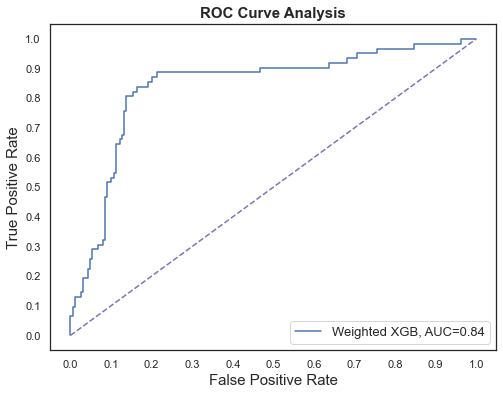

In [82]:
# Instantiate the classfiers and make a list
classifiers_name = [rs_xg.best_estimator_
                ]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers_name:
    yproba = cls.predict_proba(x_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table['names'] = ['Weighted XGB']
result_table.set_index('names', inplace=True)

#Plot the figure
fig = plt.figure(figsize=(8,6))

sns.set_style("white")

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.2f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='m', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

Although our model performed better in predicting non-fraud cases, the model has performed very well on fraud cases as well. We have a higher false alarm than frauds escaping the detection. It is better in our case to identify more frauds than to let fraud cases escape detection. Thus, this model has succeeded in its purpose to detect fraud claims. Unlike the baseline model that sacrifices too much resources into investigations and hinder customer experience, we are also able to balance this out in this model. We can detect more fraud and we are able to balance this with correct prediction of non-fraud cases. 

### Top features

Importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance. This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

**Weight:**

The number of times a feature is used to split the data across all trees. The final measure, implemented exclusively in XGBoost, is counting the number of samples affected by the splits based on a feature.

The figure below summarizes the top 20 ranked by feature importance, based on weight. Drivers with hobbies such as chess, cross-fit seemed to be more prone to frauds. Incident severity and property claim are amongst the highest as well. Interaction terms such as premium and total claim amount, vehicle claim amount and incident severity were also top features by weight. 

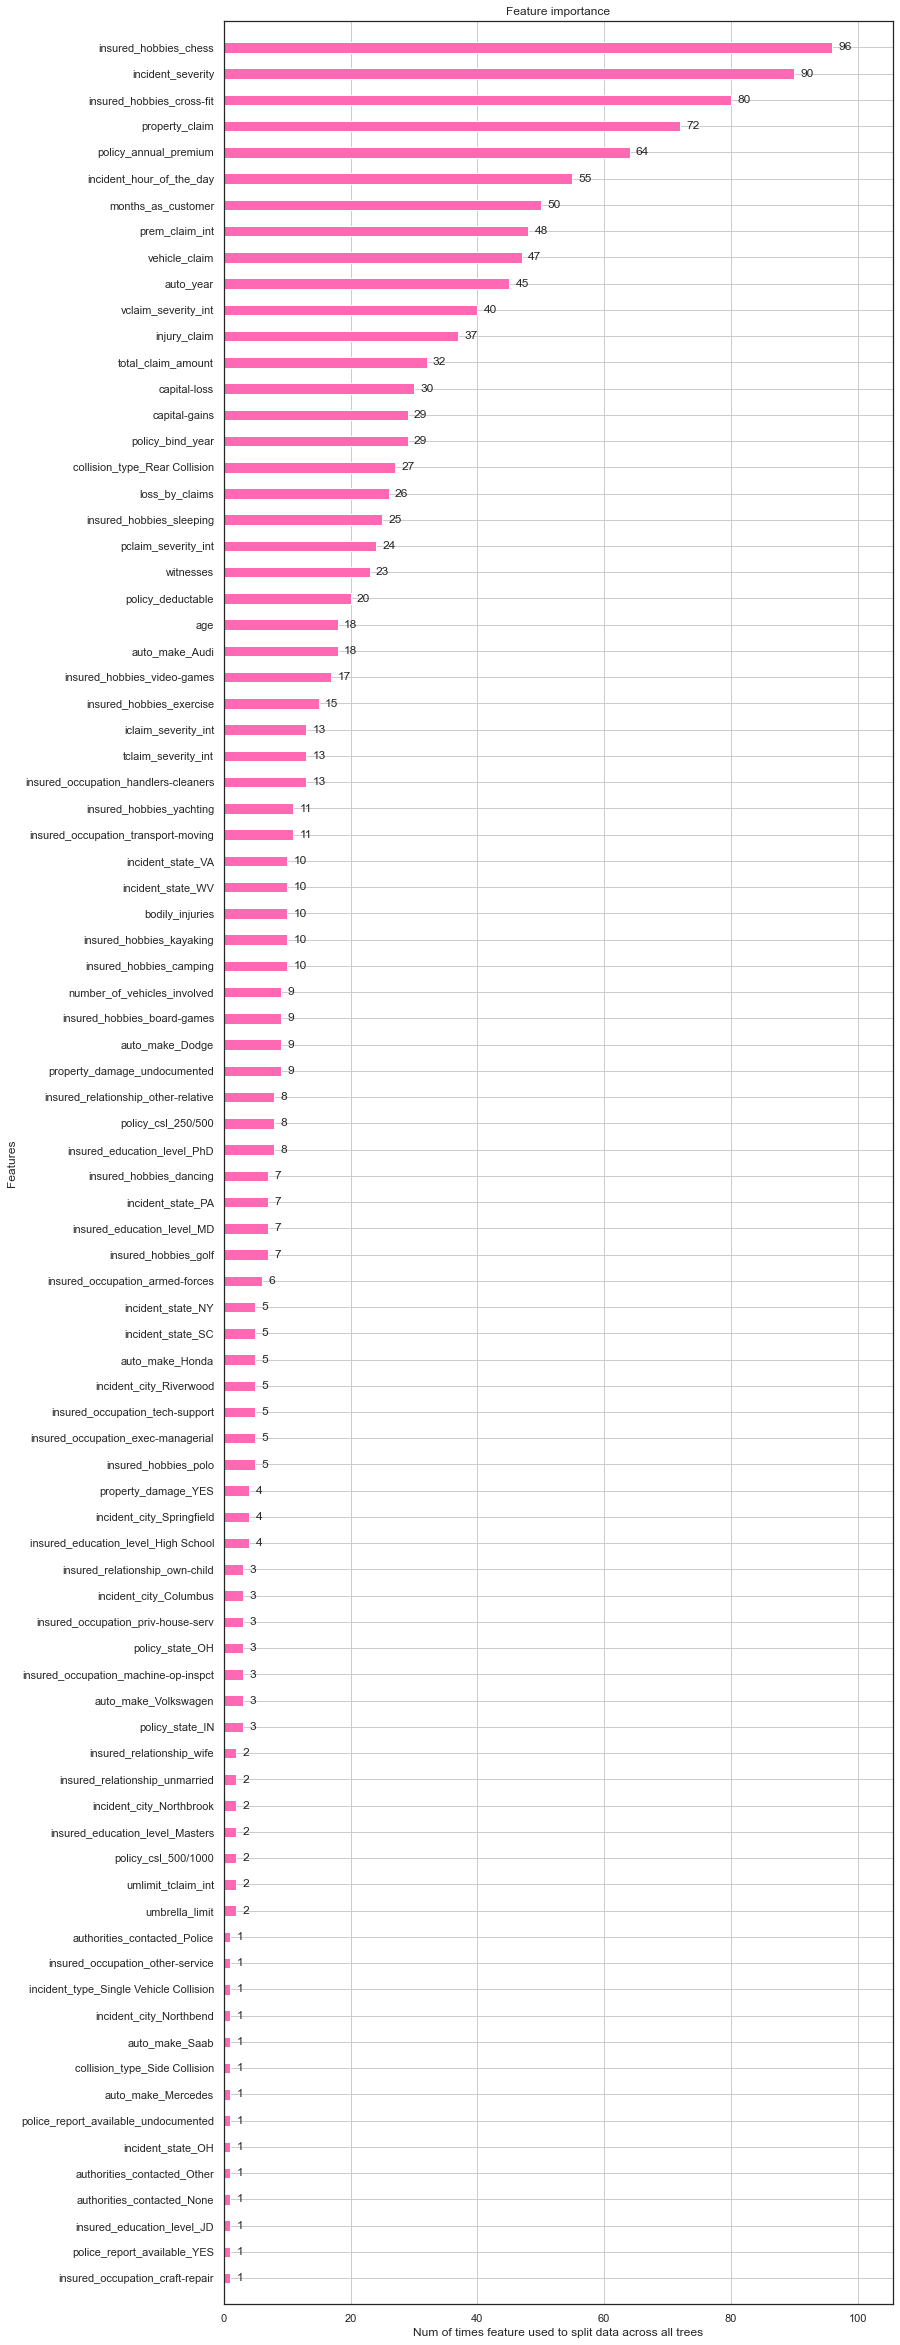

In [83]:
# plot feature importance

fig, ax = plt.subplots(figsize=(12, 42))
plot_importance(rs_xg.best_estimator_, importance_type='weight', 
                max_num_features=200, height=0.4, ax=ax, xlabel='Num of times feature used to split data across all trees',
               color='hotpink');


**Gain:**

It is sometimes called “Gini importance” or “mean decrease impurity” and is defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node) averaged over all trees of the ensemble.

<br>
<details><summary>More information on mean decrease in impurity:</summary>

Gini Impurity measures how often a randomly chosen record from the data set used to train the model will be incorrectly labelled if it was randomly labelled according to the distribution of labels in the subset (e.g., if half of the records in a group are "A" and the other half of the records are "B", a record randomly labelled based on the composition of that group has a 50% chance of being labelled incorrectly). Gini Impurity reaches zero when all records in a group fall into a single category (i.e., if there is only one possible label in a group, a record will be given that label 100% of the time). This measure is essentially the probability of a new record being incorrectly classified at a given node in a Decision Tree, based on the training data.

Gini Importance can be leveraged to calculate Mean Decrease in Gini, which is a measure of variable importance for estimating a target variable. Mean Decrease in Gini is the average (mean) of a variable’s total decrease in node impurity, weighted by the proportion of samples reaching that node in each individual decision tree in the random forest. This is effectively a measure of how important a variable is for estimating the value of the target variable across all the trees that make up the forest. A higher Mean Decrease in Gini indicates higher variable importance.

The most important variables to the model will be highest in the plot and have the largest Mean Decrease in Gini Values, conversely, the least important variable will be lowest in the plot and have the smallest Mean Decrease in Gini values.
    
</details>

The figure below summarizes the top 20 ranked by feature importance, based on weight. Incident severity is once again amongst the most important. Hobbies such as chess and CrossFit are also amongst the top features when looking at mean decrease in impurity. Interaction terms such as total claims and incident severity are top features as well. 

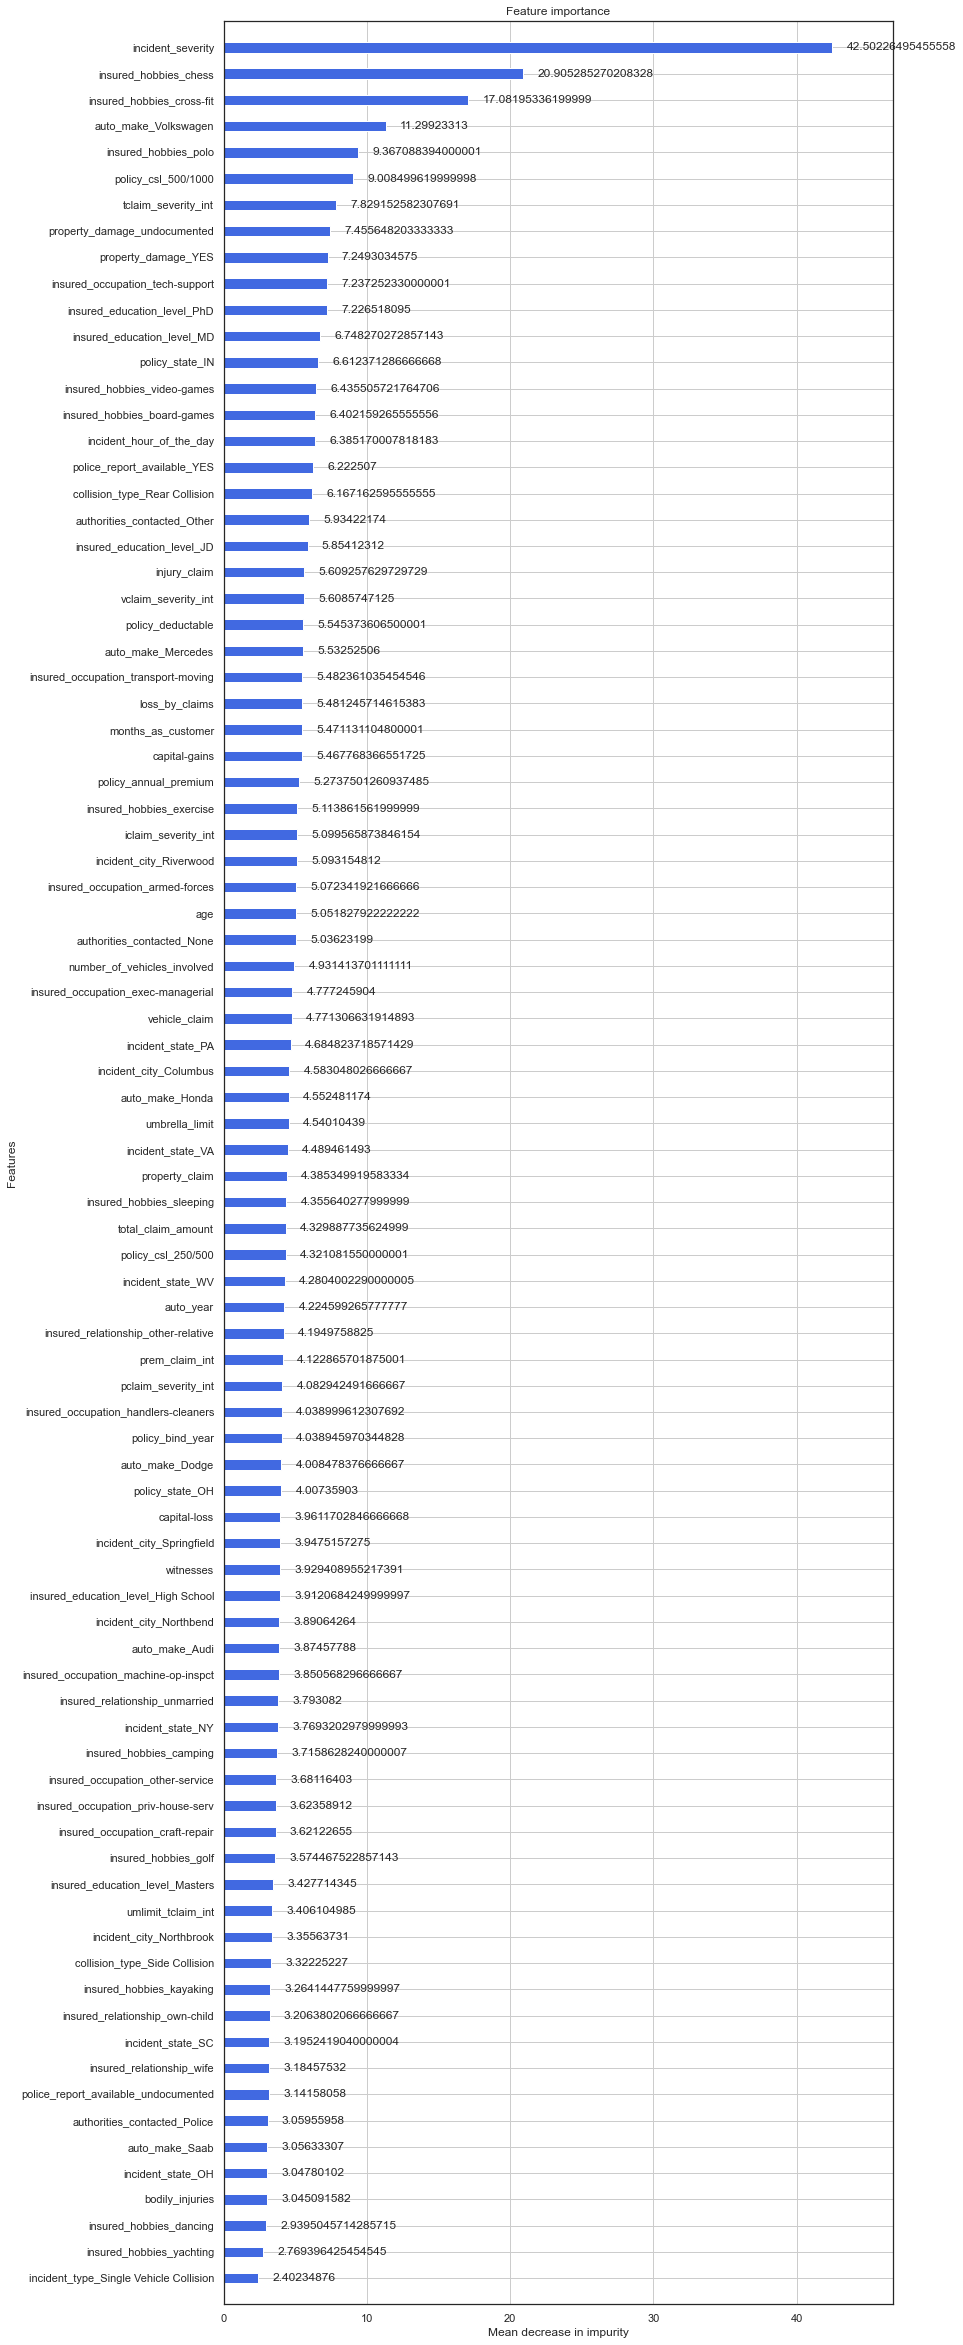

In [84]:
# plot feature importance
fig, ax = plt.subplots(figsize=(12, 42))
plot_importance(rs_xg.best_estimator_, importance_type='gain', 
                max_num_features=200, height=0.4, ax=ax, xlabel='Mean decrease in impurity', color='royalblue');